<a href="https://colab.research.google.com/github/Messmania/Low-Grade-Glioma-Classification-using-ML-Models/blob/main/LMP1210_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Submitted by: Monika, Setareh and Tamara

# **Classification of Low-grade Gliomas Using Ensembling and OpenAI Embeddings**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Global Variables
drive_path = 'drive/MyDrive/'

In [ ]:
#import statements
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve, auc, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_classification
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score
import matplotlib.patches as mpatches
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE

# Data loading
Loads dataset and labels from two files

In [ ]:
#Utilities
def encode_categorical_column(data):
    """
    One-hot encoding of categorical column Race into corresponding numerical columns
    """
    encRace= pd.get_dummies(data["Race"], prefix="Race")
    new_data = pd.concat([encRace, data], axis=1).drop("Race", axis=1)
    return new_data

def load_data():
    """loads data from the file and filters LGG data for further analysis"""
    raw_data = pd.read_csv(drive_path + "TCGA_InfoWithGrade.csv")
    raw_data = raw_data[raw_data.Grade == 0].drop("Grade", axis=1)  #no-encoding data for graphs
    lgg_data = encode_categorical_column(raw_data)
    # print(lgg_data)
    return lgg_data, raw_data


def load_labels():
    """ Labels are in a separate unprocessed data file so we must process it according to the data processing done in other data file"""
    all_mutations = pd.read_csv(drive_path + "TCGA_GBM_LGG_Mutations_all.csv")
    #removing missing values and 'not reported'
    filtered = all_mutations[(all_mutations.Grade == "LGG") & (all_mutations.Gender != "--") & (all_mutations.Primary_Diagnosis != "--") & (all_mutations.Age_at_diagnosis  != "--") & (all_mutations.Race != "not reported")]

    #To do 5-class classification, simply uncomment the 5-class mapping line below and comment the 3-class mapping line and vice-versa
    #3-class mapping
    mapping = {"Astrocytoma, anaplastic": "Astro", "Oligodendroglioma, anaplastic": "Oligo", "Mixed glioma": "Mixed",  "Astrocytoma, NOS": "Astro", "Oligodendroglioma, NOS": "Oligo" }
    #5-class mapping
    # mapping = {"Astrocytoma, anaplastic": "AA", "Oligodendroglioma, anaplastic": "OA", "Mixed glioma": "M",  "Astrocytoma, NOS": "AN", "Oligodendroglioma, NOS": "ON" }
    labels = filtered["Primary_Diagnosis"].replace(mapping)
    return labels

lgg_data, raw_data = load_data()
labels = load_labels()


#Data Exploration

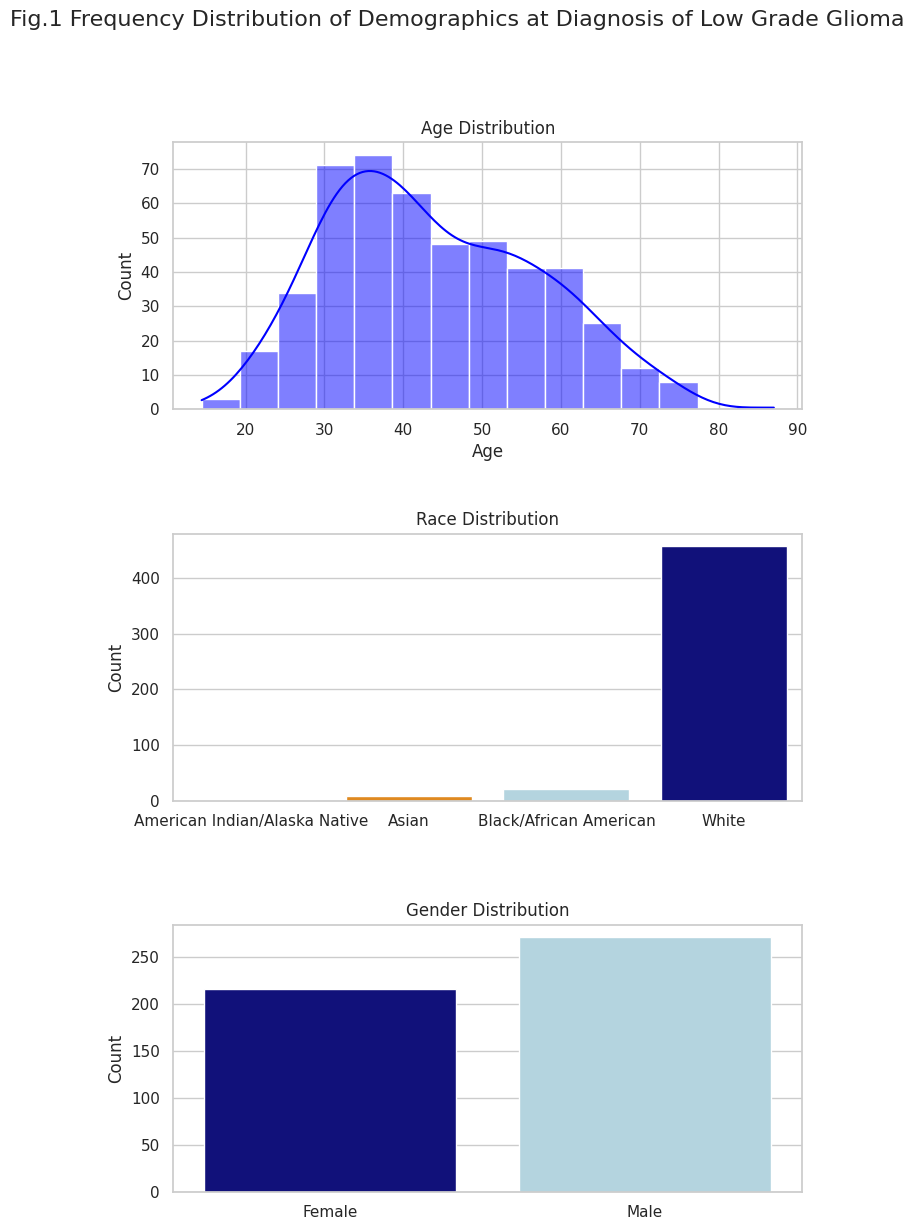

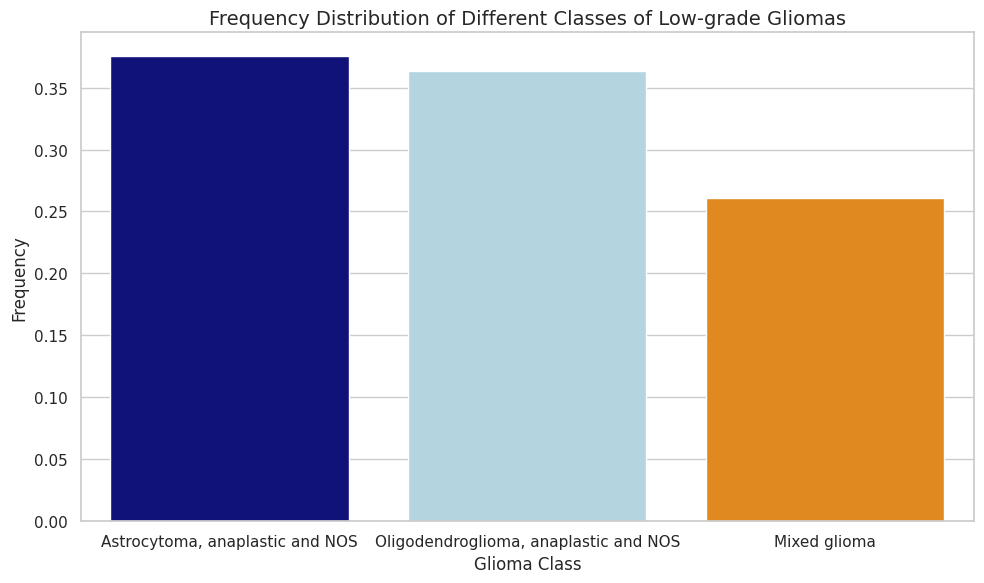

In [ ]:
#Exploratory Data Analysis
def show_demographics_distribution():
    """ Shows the distribution of demographic columns: Race, Gender, Age to spot any imbalance"""
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(3, 1, figsize=(8, 12))

    # Assume age, race, and gender data are correctly loaded into these variables
    age, race, gender = lgg_data.Age_at_diagnosis, raw_data.Race, lgg_data.Gender

    # Mapping
    race_ax = race.map({0: "White", 1: "Black/African American", 2: "Asian", 3: "American Indian/Alaska Native"})
    gender_ax = gender.map({0: "Male", 1: "Female"})

    # Colors mapped manually to ensure clarity and avoid cycling
    race_colors = race_ax.map({"White": "orange", "Black/African American": "darkblue", "Asian": "lightblue", "American Indian/Alaska Native": "green"}).values
    gender_colors = gender_ax.map({"Male": "darkblue", "Female": "lightblue"}).values

    # Age Plot
    sns.histplot(age, ax=axes[0], color="blue", kde=True)
    axes[0].set_title("Age Distribution")
    axes[0].set(xlabel="Age", ylabel="Count")

    # Race Plot
    race_counts = race_ax.value_counts().sort_index()
    sns.barplot(x=race_counts.index, y=race_counts.values, ax=axes[1], palette=["grey",  "darkorange", "lightblue", "darkblue"])
    axes[1].set_title("Race Distribution")
    axes[1].set(ylabel="Count", xlabel="")

    # Gender Plot
    gender_counts = gender_ax.value_counts().sort_index()
    sns.barplot(x=gender_counts.index, y=gender_counts.values, ax=axes[2], palette=["darkblue", "lightblue"])
    axes[2].set_title("Gender Distribution")
    axes[2].set(ylabel="Count", xlabel="")

    plt.tight_layout(pad=3.0)
    plt.suptitle("Fig.1 Frequency Distribution of Demographics at Diagnosis of Low Grade Glioma", fontsize=16, y=1.05)
    plt.show()

def show_class_distributions():
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    freq_distribution = labels.value_counts(normalize=True)

    # Use 3-class mapping or 5-class mapping based on your needs
    # 3-class mapping
    mapping = {"Astro": "Astrocytoma, anaplastic and NOS", "Oligo": "Oligodendroglioma, anaplastic and NOS", "Mixed": "Mixed glioma"}
    #5-class mapping
    # mapping = {"AA": "Astrocytoma, anaplastic", "OA": "Oligodendroglioma, anaplastic", "M" : "Mixed glioma",  "AN": "Astrocytoma, NOS", "ON": "Oligodendroglioma, NOS" }

    freq_labels = freq_distribution.rename(mapping)

    custom_colors = ["darkblue", "lightblue", "darkorange"]
    sns.barplot(x=freq_labels.index, y=freq_labels.values, palette=custom_colors)
    plt.xlabel("Glioma Class", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.title("Frequency Distribution of Different Classes of Low-grade Gliomas", fontsize=14)
    plt.xticks(rotation=0)  # Rotates the x labels to make them more readable
    plt.tight_layout()
    plt.show()

show_demographics_distribution()
show_class_distributions()

# Data Splitting

In [ ]:
def split_data(features, labels):
    """Splits data into training and testing"""
    assert(len(features) == len(labels)) #check
    X_training, X_testing, Y_training, Y_testing = train_test_split(features, labels, test_size=0.3, random_state=40)
    return {'features': (X_training, X_testing), 'target': (Y_training, Y_testing) }


features, target = split_data(lgg_data, labels).values()
X_training, X_testing = features
Y_training, Y_testing = target

In [ ]:
#Troubleshooting and verification
# print(f"Testing length: {len(X_training)} {type(X_training)} \n{X_training.iloc[0,:]}")
# print(f"\nFor training data{len(Y_training)} {Y_training.value_counts()}")
# print(f"\nFor testing data: {len(Y_testing)} \n{Y_testing.value_counts()}")

# Neural Network: Multilayer perceptron

In [ ]:
#MLP
def run_mlp():
    mlp = MLPClassifier(max_iter=300, random_state=92)
    mlp.fit(X_training, Y_training)

    predictions = mlp.predict(X_testing)
    accuracy_testing = accuracy_score(predictions, Y_testing)
    print(f"Initial accuracy with default params on testing data {accuracy_testing}")
    print(classification_report(predictions, Y_testing))

    return mlp

mlp = run_mlp()

Initial accuracy with default params on testing data 0.6462585034013606
              precision    recall  f1-score   support

       Astro       0.81      0.65      0.72        78
       Mixed       0.10      0.27      0.14        11
       Oligo       0.77      0.71      0.74        58

    accuracy                           0.65       147
   macro avg       0.56      0.54      0.54       147
weighted avg       0.74      0.65      0.69       147



In [ ]:
#tuning
def tune_mlp():
  parameter_space = {
    'hidden_layer_sizes': [(300,), (340,) ],
    'activation': ['tanh', 'relu', 'logistic'], #activation for hidden layers
    'solver': ['sgd', 'adam'],                  #optimization algo used by MLP
    'alpha': [0.01, 0.05],                      #prevents overfitting
    'learning_rate': ['constant','adaptive'],   #step size
  }

  mlp_clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
  mlp_clf.fit(X_training, Y_training)

  print(f"Best score:{mlp_clf.best_score_} \nBest params:{mlp_clf.best_params_}")
  optimized_mlp = mlp_clf.best_estimator_
  predictions = optimized_mlp.predict(X_testing)
  accuracy_clf = accuracy_score(predictions, Y_testing)
  print(f"\nTuned accuracy on testing data {accuracy_clf}")
  print(classification_report(predictions, Y_testing))
  return optimized_mlp


optimized_mlp = tune_mlp()

Best score:0.5500957408269938 
Best params:{'activation': 'logistic', 'alpha': 0.05, 'hidden_layer_sizes': (340,), 'learning_rate': 'constant', 'solver': 'adam'}

Tuned accuracy on testing data 0.6666666666666666
              precision    recall  f1-score   support

       Astro       0.84      0.65      0.74        81
       Mixed       0.06      0.29      0.11         7
       Oligo       0.81      0.73      0.77        59

    accuracy                           0.67       147
   macro avg       0.57      0.56      0.54       147
weighted avg       0.79      0.67      0.72       147



# Decision Trees: RandomForest

[0.961764705882353, 0.9970588235294118, 0.9970588235294118, 0.9970588235294118, 0.9970588235294118, 0.9970588235294118, 0.9970588235294118, 0.9970588235294118, 1.0, 1.0] [0.46258503401360546, 0.46938775510204084, 0.47619047619047616, 0.46938775510204084, 0.46258503401360546, 0.46938775510204084, 0.46258503401360546, 0.4557823129251701, 0.4489795918367347, 0.46258503401360546]


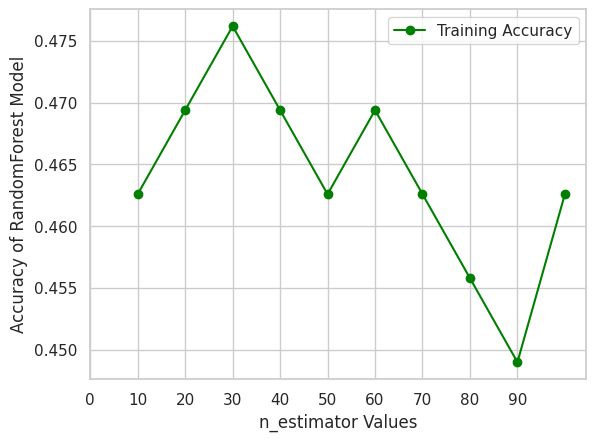

In [ ]:
#Figuring out the best number of estimators with the highest accuracy for testing predction
n_estimators = [10,20,30,40,50,60,70,80,90,100]

# storing accuracies
train_accuracies = []
test_accuracies = []

for value in n_estimators:

    modelRF = RandomForestClassifier(n_estimators=value, random_state=0)
    modelRF.fit(X_training, Y_training)

    # training set
    Y_train_pred = modelRF.predict(X_training)
    train_accuracy = accuracy_score(Y_training, Y_train_pred)
    train_accuracies.append(train_accuracy)

    # Testing set
    Y_test_pred = modelRF.predict(X_testing)
    test_accuracy = accuracy_score(Y_testing, Y_test_pred)
    test_accuracies.append(test_accuracy)

print(train_accuracies,test_accuracies)

#plt.plot(n_estimators, train_accuracies, color="blue", marker="x")
plt.plot(n_estimators, test_accuracies, color="green", marker="o")
plt.xticks(range(0, 100, 10))
plt.xlabel("n_estimator Values")
plt.ylabel("Accuracy of RandomForest Model")
plt.legend(labels=["Training Accuracy", "Test Accuracy"])
plt.savefig("plotRF.jpg")

In [ ]:
# RF classifier with the best estimator number, with the highest accruacy, n_estimator = 20

param_grid = {
    'max_depth': [None, 5,10, 15, 20,25, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4,6,8,10],
    'max_features': ['auto', 'sqrt', "log2"]
}

# Initialize the model
rf = RandomForestClassifier(n_estimators = 20)

# Initialize Grid Search
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit Grid Search to the data
grid_search.fit(X_training, Y_training)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Fitting 3 folds for each of 378 candidates, totalling 1134 fits
Best Parameters: {'max_depth': 25, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2}
Best Score: 0.5823112353154272


In [ ]:
RfOptimized = RandomForestClassifier(n_estimators = 20, max_depth = None, max_features = 'auto', min_samples_leaf = 6, min_samples_split = 5)
RfOptimized.fit(X_training, Y_training)

rf_pred = RfOptimized.predict(X_testing)
print(f"Accuracy of RF: {accuracy_score(Y_testing, rf_pred)}")
print(classification_report(rf_pred, Y_testing))

Accuracy of RF: 0.673469387755102
              precision    recall  f1-score   support

       Astro       0.92      0.64      0.76        90
       Mixed       0.00      0.00      0.00         0
       Oligo       0.77      0.72      0.75        57

    accuracy                           0.67       147
   macro avg       0.56      0.45      0.50       147
weighted avg       0.86      0.67      0.75       147



# Ensemble Model

In [ ]:
# Fit the models to the training data and get the validation accuracy or another performance metric
#mlp.fit(X_training, Y_training)
#grid_search.fit(X_training, Y_training)

# You could use cross-validation scores as weights, or directly the accuracy on a validation set
# Here we're using training set accuracy for simplicity (replace with validation accuracy for a better approach)
mlp_accuracy = accuracy_score(Y_training, optimized_mlp.predict(X_training))
rf_accuracy = accuracy_score(Y_training, RfOptimized.predict(X_training))

# Calculate weights based on accuracy
total_accuracy = mlp_accuracy + rf_accuracy
mlp_weight = mlp_accuracy / total_accuracy
rf_weight = rf_accuracy / total_accuracy

# Create ensemble model with weighted average voting
ensemble_model = VotingClassifier(estimators=[
    ('mlp', optimized_mlp),
    ('rf', RfOptimized)
], voting='soft', weights=[mlp_weight, rf_weight])

# Train the ensemble model
ensemble_model.fit(X_training, Y_training)

# Predict on the testing data
ensemble_predictions = ensemble_model.predict(X_testing)

# Evaluate the ensemble model
ensemble_accuracy = accuracy_score(Y_testing, ensemble_predictions)
ensemble_classification_report = classification_report(Y_testing, ensemble_predictions)

print(f"Accuracy of the ensemble model on testing data: {ensemble_accuracy}")
print("Classification Report:\n", ensemble_classification_report)

Accuracy of the ensemble model on testing data: 0.6802721088435374
Classification Report:
               precision    recall  f1-score   support

       Astro       0.66      0.87      0.75        63
       Mixed       0.17      0.03      0.05        31
       Oligo       0.76      0.83      0.79        53

    accuracy                           0.68       147
   macro avg       0.53      0.58      0.53       147
weighted avg       0.59      0.68      0.62       147



In [ ]:
# Using stacking for averaging the models in the ensemble

# Initialize the Stacking Classifier with the Logistic Regression meta-classifier
stacking_classifier = StackingClassifier(
    estimators=[
        ('mlp', optimized_mlp),
        ('rf', RfOptimized)
    ],
    final_estimator=LogisticRegression()
)

# Train the stacking classifier
stacking_classifier.fit(X_training, Y_training)

# Predict on the testing data
stacking_predictions = stacking_classifier.predict(X_testing)

# Evaluate the stacking classifier
stacking_accuracy = accuracy_score(Y_testing, stacking_predictions)
stacking_classification_report = classification_report(Y_testing, stacking_predictions)

print(f"Accuracy of the stacking classifier on testing data: {stacking_accuracy}")
print("Classification Report for Stacking Classifier:\n", stacking_classification_report)

Accuracy of the stacking classifier on testing data: 0.673469387755102
Classification Report for Stacking Classifier:
               precision    recall  f1-score   support

       Astro       0.67      0.86      0.75        63
       Mixed       0.50      0.03      0.06        31
       Oligo       0.69      0.83      0.75        53

    accuracy                           0.67       147
   macro avg       0.62      0.57      0.52       147
weighted avg       0.64      0.67      0.61       147



In [ ]:
# Define the base models
base_models = [
    ('mlp', optimized_mlp),
    ('RF', RfOptimized),
    ('svc', SVC(probability=True, random_state=42)),

]

# Define the meta-learner
meta_learner = LogisticRegression(random_state=42)

# Create the stacking classifier
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_learner, cv=5)

# Train the stacking classifier
stacking_model.fit(X_training, Y_training)

# Evaluate the model
stacking_pred = stacking_model.predict(X_testing)
stacking_accuracy = accuracy_score(Y_testing, stacking_pred)
stacking_classification_report = classification_report(Y_testing, stacking_pred)

print(f"Accuracy of the stacking model: {stacking_accuracy}")
print("Classification Report for Stacking Classifier:\n", stacking_classification_report)

Accuracy of the stacking model: 0.673469387755102
Classification Report for Stacking Classifier:
               precision    recall  f1-score   support

       Astro       0.67      0.87      0.76        63
       Mixed       0.00      0.00      0.00        31
       Oligo       0.68      0.83      0.75        53

    accuracy                           0.67       147
   macro avg       0.45      0.57      0.50       147
weighted avg       0.53      0.67      0.59       147



# Removal of mixed gliomas

## Prepare new dataset

In [ ]:
#Remove mixed gliomas
#Load raw data file
all_mutations = pd.read_csv(drive_path + "TCGA_GBM_LGG_Mutations_all.csv")
#mappings for data preprocessing
race_map = {"white": 0, "black or african american": 1, "asian": 2, "american indian or alaska native": 3 }
mutation_map = {'MUTATED': 1, 'NOT_MUTATED': 0}
gender_map = {'Male': 0, 'Female': 1}
glioma_class_map = {"Astrocytoma, anaplastic": "Astro", "Oligodendroglioma, anaplastic": "Oligo", "Astrocytoma, NOS": "Astro", "Oligodendroglioma, NOS": "Oligo" }

def convert_to_years(text):
    # Split the text into years and days
    parts = text.split()
    years = float(parts[0])  # Convert years to float
    days = float(parts[2]) if len(parts) > 2 else 0  # Convert days to float
    years_from_days = round(days / 365, 2)
    total_years = years + years_from_days
    return total_years

def load_no_mixed_data():
    """loads features and labels without mixed gliomas, by processing the raw data file from scratch"""
    feature_column_maps = {**race_map, **mutation_map, **gender_map}
    filtered = all_mutations[(all_mutations.Primary_Diagnosis != "Mixed glioma") & (all_mutations.Grade == "LGG") & (all_mutations.Gender != "--") & (all_mutations.Primary_Diagnosis != "--") & (all_mutations.Age_at_diagnosis  != "--") & (all_mutations.Race != "not reported")]
    filtered.loc[:, "Age_at_diagnosis"] = filtered["Age_at_diagnosis"].apply(convert_to_years) #conversion of text to float in years
    new_labels = filtered.Primary_Diagnosis.replace(glioma_class_map)
    features = filtered.replace(feature_column_maps).drop(["Grade", "Primary_Diagnosis", "Case_ID", "Project"], axis=1)
    new_features = encode_categorical_column(features) #encoding for Race
    return new_features, new_labels

new_features, new_labels = load_no_mixed_data()

#Dataset without mixed gliomas, use these going further
features, target = split_data(new_features, new_labels).values()
X_training, X_testing = features
Y_training, Y_testing = target

## Rerun all models

In [ ]:
#New MLP on dataset without mixed gliomas
def run_new_mlp():
    mlp = MLPClassifier(max_iter=300, random_state=92)
    mlp.fit(X_training, Y_training)

    predictions = mlp.predict(X_testing)
    accuracy_testing = accuracy_score(predictions, Y_testing)
    mlp_classification_report = classification_report(Y_testing, predictions)

    print(f"\nAccuracy of the MLP: {accuracy_testing}")
    print("Classification Report for MLP:\n", mlp_classification_report)

    return mlp

mlp2 = run_new_mlp()
mlp2.fit(X_training, Y_training)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(



Accuracy of the MLP: 0.8611111111111112
Classification Report for MLP:
               precision    recall  f1-score   support

       Astro       0.81      0.94      0.87        54
       Oligo       0.93      0.78      0.85        54

    accuracy                           0.86       108
   macro avg       0.87      0.86      0.86       108
weighted avg       0.87      0.86      0.86       108



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(max_iter=300, random_state=92)

In [ ]:
#New RF model without mixed glioma

param_grid = {
    'max_depth': [None, 5,10, 15, 20,25, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4,6,8,10],
    'max_features': ['auto', 'sqrt', "log2"]
}

# Initialize the model
rf2 = RandomForestClassifier(n_estimators = 20)

# Initialize Grid Search
grid_search2 = GridSearchCV(estimator=rf2, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit Grid Search to the data
grid_search2.fit(X_training, Y_training)

# Get the best parameters and the best score
best_params2 = grid_search2.best_params_
best_score2 = grid_search2.best_score_

print("Best Parameters:", best_params2)
print("Best Score:", best_score2)

RfOptimized2 = RandomForestClassifier(random_state=137, n_estimators = 20, max_depth = 10, max_features = 'log2', min_samples_leaf = 1, min_samples_split = 10)
RfOptimized2.fit(X_training, Y_training)
predictions = RfOptimized2.predict(X_testing)
accuracy_testing = accuracy_score(predictions, Y_testing)
rf_classification_report = classification_report(Y_testing, predictions)

print(f"\nAccuracy of the Random Forest: {accuracy_testing}")
print("Classification Report for Random Forest:\n", rf_classification_report)

Fitting 3 folds for each of 378 candidates, totalling 1134 fits
Best Parameters: {'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 4, 'min_samples_split': 5}
Best Score: 0.8293650793650794

Accuracy of the Random Forest: 0.8240740740740741
Classification Report for Random Forest:
               precision    recall  f1-score   support

       Astro       0.79      0.89      0.83        54
       Oligo       0.87      0.76      0.81        54

    accuracy                           0.82       108
   macro avg       0.83      0.82      0.82       108
weighted avg       0.83      0.82      0.82       108



/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


## Ensemble for 2-level classification


In [ ]:
# New ensemble model using 2-level classification
# Define the base models
base_models2 = [
    ('mlp', mlp2),
    ('rf2', RfOptimized2)
]

# Define the meta-learner
meta_learner = LogisticRegression(random_state=42)

# Create the stacking classifier
stacking_model2 = StackingClassifier(estimators=base_models2, final_estimator=meta_learner, cv=5)

# Train the stacking classifier
stacking_model2.fit(X_training, Y_training)

# Evaluate the model
stacking_pred2 = stacking_model2.predict(X_testing)
stacking_accuracy = accuracy_score(Y_testing, stacking_pred2)
stacking_classification_report = classification_report(Y_testing, stacking_pred2)

print(f"Accuracy of the stacking model: {stacking_accuracy}")
print("Classification Report for Stacking Classifier:\n", stacking_classification_report)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy of the stacking model: 0.8425925925925926
Classification Report for Stacking Classifier:
               precision    recall  f1-score   support

       Astro       0.79      0.93      0.85        54
       Oligo       0.91      0.76      0.83        54

    accuracy                           0.84       108
   macro avg       0.85      0.84      0.84       108
weighted avg       0.85      0.84      0.84       108



In [ ]:
# Trying support vector machines as my meta-learner for the stacking portion

# Initialize AdaBoost as the meta-learner
meta_learner_adaboost = AdaBoostClassifier(random_state=42)

# Create the stacking classifier with AdaBoost as the meta-learner
stacking_model2_adaboost = StackingClassifier(estimators=base_models2, final_estimator=meta_learner_adaboost, cv=5)

# Train the stacking classifier
stacking_model2_adaboost.fit(X_training, Y_training)

# Evaluate the model
stacking_pred2_adaboost = stacking_model2_adaboost.predict(X_testing)
stacking_accuracy_adaboost = accuracy_score(Y_testing, stacking_pred2_adaboost)
stacking_classification_report_adaboost = classification_report(Y_testing, stacking_pred2_adaboost)

print(f"Accuracy of the stacking model with AdaBoost meta-learner: {stacking_accuracy_adaboost}")
print("Classification Report for Stacking Classifier with AdaBoost meta-learner:\n", stacking_classification_report_adaboost)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy of the stacking model with AdaBoost meta-learner: 0.7870370370370371
Classification Report for Stacking Classifier with AdaBoost meta-learner:
               precision    recall  f1-score   support

       Astro       0.77      0.81      0.79        54
       Oligo       0.80      0.76      0.78        54

    accuracy                           0.79       108
   macro avg       0.79      0.79      0.79       108
weighted avg       0.79      0.79      0.79       108



Feature Importances:
Feature 12: Importance = 0.1256495634072621
Feature 6: Importance = 0.061594389211801305
Feature 8: Importance = 0.05070568406558436
Feature 9: Importance = 0.046192055736815466
Feature 17: Importance = 0.03093716255391879
Feature 24: Importance = 0.030743031578415392
Feature 7: Importance = 0.027884929280036847
Feature 19: Importance = 0.01964184978224824
Feature 15: Importance = 0.014314669978505034
Feature 13: Importance = 0.010843080211247684
Feature 11: Importance = 0.010311504919251993
Feature 22: Importance = 0.009102247758604203
Feature 1: Importance = 0.008881674049992998
Feature 10: Importance = 0.0062578763211557364
Feature 20: Importance = 0.005788800857446145
Feature 14: Importance = 0.005777842590515159
Feature 2: Importance = 0.005527158498996168
Feature 25: Importance = 0.005432648807336881
Feature 3: Importance = 0.005346904393494867
Feature 5: Importance = 0.0043571086077913435
Feature 23: Importance = 0.0039251915669003025
Feature 18: Importance 

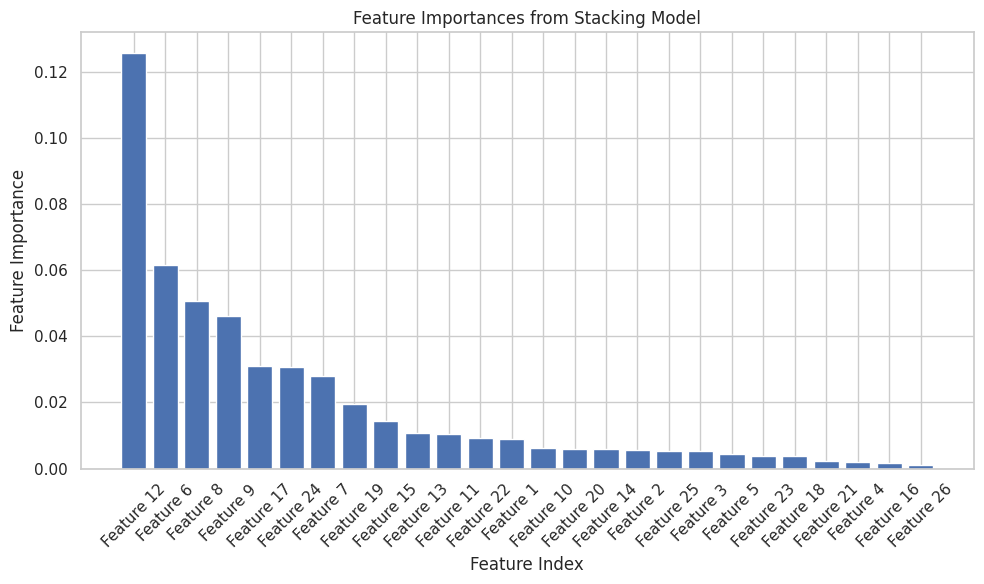

In [ ]:
# Predict the classes for the test data
y_pred = stacking_model2.predict(X_testing)

# Aggregate feature importances from individual models
feature_importances = None
for estimator in stacking_model2.estimators_:
    if hasattr(estimator, 'feature_importances_'):
        if feature_importances is None:
            feature_importances = estimator.feature_importances_
        else:
            feature_importances += estimator.feature_importances_

# Normalize feature importances
feature_importances /= len(stacking_model2.estimators_)

# Sort the indices based on importance scores
sorted_indices = feature_importances.argsort()[::-1]

print("Feature Importances:")
for idx in sorted_indices:
    print(f"Feature {idx+1}: Importance = {feature_importances[idx]}")

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_indices)), feature_importances[sorted_indices])
plt.xlabel('Feature Index')
plt.ylabel('Feature Importance')
plt.title('Feature Importances from Stacking Model')
plt.xticks(range(len(sorted_indices)), [f'Feature {idx+1}' for idx in sorted_indices], rotation=45)
plt.tight_layout()
plt.show()

# Embeddings
Also uses 2-level classification

In [ ]:
pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.3/268.3 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 9.4 MB/s eta 0:00:00


In [ ]:
from sklearn.preprocessing import MinMaxScaler

## Preprocess data for embeddings

### Trials for Input formats
Can be skipped as these are iterations which were tried out.

In [ ]:
#Trials for input formats
def get_text_list(data):
	columns = []
	for _, row in data.iterrows():
		row_value = ""
		for col in data.columns:
			row_value += str(row[col]) + ' '
		columns.append(row_value)
	return columns

def data_preprocessing_vanilla():
	filtered = all_mutations[(all_mutations.Primary_Diagnosis != "Mixed glioma") & (all_mutations.Grade == "LGG") & (all_mutations.Gender != "--") & (all_mutations.Primary_Diagnosis != "--") & (all_mutations.Age_at_diagnosis  != "--") & (all_mutations.Race != "not reported")]
	#NOTE: labels can be picked from NO glioma code chunk as new_labels
	filtered_data = filtered.drop(["Grade", "Primary_Diagnosis", "Case_ID", "Project"], axis=1)
	# print(f"HERE: {filtered_data}")
	row_list = get_text_list(filtered_data)
	# print(f"Feature length: {len(row_list)}")
	return pd.DataFrame(row_list)

def get_gene_names(data):
	index_of_first_gene = data.columns.get_loc('IDH1')
	gene_names = data.columns[index_of_first_gene:]
	genes = ' '.join(gene_names)
	return genes

def data_preprocessing_with_gene_names():
	def get_text_list_with_genes(data, gene_names):
		columns = []
		index_of_first_gene = data.columns.get_loc('IDH1')

		for _, row in data.iterrows():
			row_value = ""
			for col in data.columns[:index_of_first_gene]:
				row_value += str(row[col]) + ' '
			row_value += gene_names + ' '
			# print(f"Row_value: {row_value}")
			for col in data.columns[index_of_first_gene:]:
				row_value += str(row[col]) + ' '
			columns.append(row_value)
		return columns
	filtered = all_mutations[(all_mutations.Primary_Diagnosis != "Mixed glioma") & (all_mutations.Grade == "LGG") & (all_mutations.Gender != "--") & (all_mutations.Primary_Diagnosis != "--") & (all_mutations.Age_at_diagnosis  != "--") & (all_mutations.Race != "not reported")]
	#NOTE: labels can be picked from NO glioma code chunk as new_labels
	filtered_data = filtered.drop(["Grade", "Primary_Diagnosis", "Case_ID", "Project"], axis=1)
	# print(f"HERE: {filtered_data}")
	gene_names = get_gene_names(filtered_data)
	print(f"Genes: {gene_names}")
	row_list = get_text_list_with_genes(filtered_data, gene_names)
	# print(f"Feature length: {len(row_list)}")
	return pd.DataFrame(row_list)

 def data_preprocessing_with_mutated_genes():
	def get_text_list_with_mutated_genes(data):
		"""Append gene names which are mutated"""
		columns = []
		index_of_first_gene = data.columns.get_loc('IDH1')
		print(f"Index: {index_of_first_gene}")
		for _, row in data.iterrows():
			row_value = ""
			for col in data.columns[:index_of_first_gene]:
				row_value += str(row[col]) + ' '
			for col in data.columns[index_of_first_gene:]:
				if(row[col] == 'MUTATED'):
					row_value += str(col) + ' '
					# print(f"Test: {row[col]}")
			columns.append(row_value)
		return columns
	filtered = all_mutations[(all_mutations.Primary_Diagnosis != "Mixed glioma") & (all_mutations.Grade == "LGG") & (all_mutations.Gender != "--") & (all_mutations.Primary_Diagnosis != "--") & (all_mutations.Age_at_diagnosis  != "--") & (all_mutations.Race != "not reported")]
	#NOTE: labels can be picked from NO glioma code chunk as new_labels
	filtered_data = filtered.drop(["Grade", "Primary_Diagnosis", "Case_ID", "Project"], axis=1)
	row_list = get_text_list_with_mutated_genes(filtered_data)
	return pd.DataFrame(row_list)

 def data_preprocess_with_years_context():
	def get_text_list_with_years_context(data):
		"""Append data with context"""
		columns = []
		index_of_first_gene = data.columns.get_loc('IDH1')
		for _, row in data.iterrows():
			row_value = "Embed these features into a vector to classify whether a patient has Astrocytoma or Oligodendroglioma. "
			for col in data.columns[:index_of_first_gene]:
				row_value += col + ':' + str(row[col]) + ', '
			row_value += 'Mutations:'
			for col in data.columns[index_of_first_gene:]:
				if(row[col] == 'MUTATED'):
					row_value += str(col) + ' '
			columns.append(row_value)
		return columns

	filtered = all_mutations[(all_mutations.Primary_Diagnosis != "Mixed glioma") & (all_mutations.Grade == "LGG") & (all_mutations.Gender != "--") & (all_mutations.Primary_Diagnosis != "--") & (all_mutations.Age_at_diagnosis  != "--") & (all_mutations.Race != "not reported")]
	#NOTE: labels can be picked from NO glioma code chunk as new_labels
	filtered_data = filtered.drop(["Grade", "Primary_Diagnosis", "Case_ID", "Project"], axis=1)
	filtered_data.loc[:, "Age_at_diagnosis"] = filtered_data["Age_at_diagnosis"].apply(convert_to_years) #conversion of text to float in years

	row_list = get_text_list_with_years_context(filtered_data)
	return pd.DataFrame(row_list)

 def data_preprocessing_without_context():
	def get_text_list_without_context(data):
		"""Append data with context"""
		columns = []
		index_of_first_gene = data.columns.get_loc('IDH1')
		for _, row in data.iterrows():
			row_value=""
			for col in data.columns[:index_of_first_gene]:
				row_value += col + ':' + str(row[col]) + ' '
			row_value += 'Mutations:'
			for col in data.columns[index_of_first_gene:]:
				if(row[col] == 'MUTATED'):
					row_value += str(col) + ' '
			columns.append(row_value)
		return columns

	filtered = all_mutations[(all_mutations.Primary_Diagnosis != "Mixed glioma") & (all_mutations.Grade == "LGG") & (all_mutations.Gender != "--") & (all_mutations.Primary_Diagnosis != "--") & (all_mutations.Age_at_diagnosis  != "--") & (all_mutations.Race != "not reported")]
	#NOTE: labels can be picked from NO glioma code chunk as new_labels
	filtered_data = filtered.drop(["Grade", "Primary_Diagnosis", "Case_ID", "Project"], axis=1)
	filtered_data.loc[:, "Age_at_diagnosis"] = filtered_data["Age_at_diagnosis"].apply(convert_to_years) #conversion of text to float in years
	row_list = get_text_list_without_context(filtered_data)
	return pd.DataFrame(row_list)

input = pd.DataFrame()

# input["features"] = data_preprocessing_vanilla()
# input.to_csv('feature_inputs_2.csv', index=False)

# input["features"] = data_preprocessing_with_gene_names()
# input.to_csv('feature_inputs_3.csv', index=False)
# input["features"] = data_preprocessing_with_mutated_genes()
# input.to_csv('feature_inputs_4.csv', index=False)

# input["features"] = data_preprocess_with_years_context()
# input.to_csv('feature_inputs_6.csv', index=False)

# input["features"] = data_preprocessing_without_context()
# input.to_csv('feature_inputs_7.csv', index=False)

### Input with context, mutations, and column names

In [ ]:
all_mutations = pd.read_csv(drive_path + "TCGA_GBM_LGG_Mutations_all.csv")

In [ ]:
def data_preprocessing_with_context():
	"""Preprocess raw data file to generate new rows with concatenated columns and context"""
	def get_text_list_with_context(data):
		"""Append data with context"""
		columns = []
		index_of_first_gene = data.columns.get_loc('IDH1')
		for _, row in data.iterrows():
			row_value = "Embed these features into a vector to classify whether a patient has Astrocytoma or Oligodendroglioma. "
			for col in data.columns[:index_of_first_gene]:
				row_value += col + ':' + str(row[col]) + ', '
			row_value += 'Mutations:'
			for col in data.columns[index_of_first_gene:]:
				if(row[col] == 'MUTATED'):
					row_value += str(col) + ' '
			columns.append(row_value)
		return columns

	filtered = all_mutations[(all_mutations.Primary_Diagnosis != "Mixed glioma") & (all_mutations.Grade == "LGG") & (all_mutations.Gender != "--") & (all_mutations.Primary_Diagnosis != "--") & (all_mutations.Age_at_diagnosis  != "--") & (all_mutations.Race != "not reported")]
	filtered_data = filtered.drop(["Grade", "Primary_Diagnosis", "Case_ID", "Project"], axis=1)
	row_list = get_text_list_with_context(filtered_data)
	return pd.DataFrame(row_list)

#save to file
input = pd.DataFrame()
input["features"] = data_preprocessing_with_context()
input.to_csv('feature_inputs_5.csv', index=False)

## Code to generate embeddings

Note: This WON'T WORK without OPENAI_API_KEY set in bash file or supplied in the code, please generate the file locally or upload a file containing the embeddings called "embeddings_response_5.csv" and skip this code chunk

In [ ]:
#Note: this WONT WORK without OPENAI_API_KEY set in bash file or supplied in the code, please generate the file locally

#Generate embeddings
from openai import OpenAI
client = OpenAI()
input = pd.read_csv("feature_inputs_5.csv") #load the file created above

def get_embedding_response(text_to_embed):
	# Embed a line of text
	response = client.embeddings.create(
		model= "text-embedding-3-small", #gives 1536 length vector for each embedding
		input=[text_to_embed]
	)
	# Extract the AI output embedding as a list of floats
	embeddings = response.data[0].embedding
	return embeddings

#astype is not needed per say, but just to make sure each row is string value
response = input["features"].astype(str).apply(get_embedding_response)
input.to_csv('embeddings_response_5.csv', index=False) #with context and mutated genes only

## Use embeddings to generate new training and testing sets

In [ ]:
all_mutations = pd.read_csv(drive_path + "TCGA_GBM_LGG_Mutations_all.csv")
glioma_class_map = {"Astrocytoma, anaplastic": "Astro", "Oligodendroglioma, anaplastic": "Oligo", "Astrocytoma, NOS": "Astro", "Oligodendroglioma, NOS": "Oligo" }

In [ ]:
def load_embeddings():
    """Loads embedded vectors from the file"""
    embeddings_file = pd.read_csv(drive_path + "embeddings_response_5.csv")
    embeddings = embeddings_file.embeddings.apply(eval).apply(np.array) #values in the file are string as "[0.2, 1.2]", this converts them to array
    return embeddings

embeddings = load_embeddings()

def load_labels_no_mixed_gliomas():
    """loads labels without mixed gliomas, by processing the raw data file"""
    filtered = all_mutations[(all_mutations.Primary_Diagnosis != "Mixed glioma") & (all_mutations.Grade == "LGG") & (all_mutations.Gender != "--") & (all_mutations.Primary_Diagnosis != "--") & (all_mutations.Age_at_diagnosis  != "--") & (all_mutations.Race != "not reported")]
    # filtered.loc[:, "Age_at_diagnosis"] = filtered["Age_at_diagnosis"].apply(convert_to_years) #conversion to float in years
    new_labels = filtered.Primary_Diagnosis.replace(glioma_class_map)
    return new_labels

new_labels = load_labels_no_mixed_gliomas()


features, target = split_data(list(embeddings.values), new_labels).values()
X_training_unscaled, X_testing_unscaled = features #these are List types now
Y_training, Y_testing = target #these are List types now

#Scale the embeddings
scaler = MinMaxScaler().fit(X_training_unscaled)
#NOTE: scaler transform method changes train and test rightly from a list of arrays to a numpy 2D array which is what we want
X_training = scaler.transform(X_training_unscaled) #scaler fitted to training data
X_testing = scaler.transform(X_testing_unscaled)

## Remake models using embeddings

### Random Forest
Max accuracy achieved is 86.11%

In [ ]:
def random_forest_embeddings():
    rf = RandomForestClassifier(random_state=148, n_estimators = 20 , max_depth= 15, max_features= 'sqrt', min_samples_leaf= 6, min_samples_split= 2)
    rf.fit(X_training, Y_training)
    predictions = rf.predict(X_testing)
    accuracy_testing = accuracy_score(predictions, Y_testing)
    print(f"RF accuracy:{accuracy_testing} \nClassification report:\n{classification_report(predictions, Y_testing)}")
    return rf

rf_embeddings = random_forest_embeddings()

### MLP
Max accuracy is 84.26%

Default config gives the best accuracy

In [ ]:
#MLP
def mlp_embeddings():
    mlp = MLPClassifier(max_iter=300, random_state=30)
    mlp.fit(X_training, Y_training)
    predictions = mlp.predict(X_testing)
    accuracy_testing = accuracy_score(predictions, Y_testing)
    print(f"Accuracy score of MLP: {accuracy_testing}\nClassification report of MLP:\n{classification_report(predictions, Y_testing)}")
    return mlp

mlp_embeddings = mlp_embeddings()

Accuracy score of MLP: 0.8425925925925926
Classification report of MLP:
              precision    recall  f1-score   support

       Astro       0.91      0.80      0.85        61
       Oligo       0.78      0.89      0.83        47

    accuracy                           0.84       108
   macro avg       0.84      0.85      0.84       108
weighted avg       0.85      0.84      0.84       108



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


### Stacking Ensemble
Max accuracy score achieved is 85.18%

In [ ]:
#Ensemble
mlp_embeddings.fit(X_training, Y_training)
rf_embeddings.fit(X_training, Y_training)

base_models3 = [
    ('mlp_embeddings', mlp_embeddings),
    ('rf_embeddings', rf_embeddings)
]

# Define the meta-learner
meta_learner = LogisticRegression(random_state=120)

# Create the stacking classifier
stacking_model3 = StackingClassifier(estimators=base_models3, final_estimator=meta_learner, cv=5)

# Train the stacking classifier
stacking_model3.fit(X_training, Y_training)

# Evaluate the model
stacking_pred3 = stacking_model3.predict(X_testing)
stacking_accuracy = accuracy_score(Y_testing, stacking_pred3)
stacking_classification_report = classification_report(Y_testing, stacking_pred3)

print(f"Classification Report for Stacking Classifier: {stacking_accuracy},\n{stacking_classification_report}")

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


NameError: name 'rf_embeddings' is not defined

# Mixed Gliomas Performance in Stacking Ensemble

In [ ]:
# How mixed gliomas get classified using the stacking method in the testing data(18 as Astro and 13 as Oligo, none as Mixed)

warnings.filterwarnings("ignore")
X_testing_np = X_testing.to_numpy()
Y_testing_np = Y_testing.to_numpy()

mixed_gliomas_test_mask_np = (Y_testing_np == 'Mixed')


# Use the mask to index the numpy arrays
X_test_mixed_gliomas_np = X_testing_np[mixed_gliomas_test_mask_np]

Y_test_mixed_gliomas_np = Y_testing_np[mixed_gliomas_test_mask_np]

stacking_predictions_mixed_gliomas_np = stacking_model.predict(X_test_mixed_gliomas_np)
print(classification_report(Y_test_mixed_gliomas_np, stacking_predictions_mixed_gliomas_np))

print(np.unique(stacking_predictions_mixed_gliomas_np, return_counts=True))


              precision    recall  f1-score   support

       Astro       0.00      0.00      0.00       0.0
       Mixed       0.00      0.00      0.00      31.0
       Oligo       0.00      0.00      0.00       0.0

    accuracy                           0.00      31.0
   macro avg       0.00      0.00      0.00      31.0
weighted avg       0.00      0.00      0.00      31.0

(array(['Astro', 'Oligo'], dtype=object), array([18, 13]))


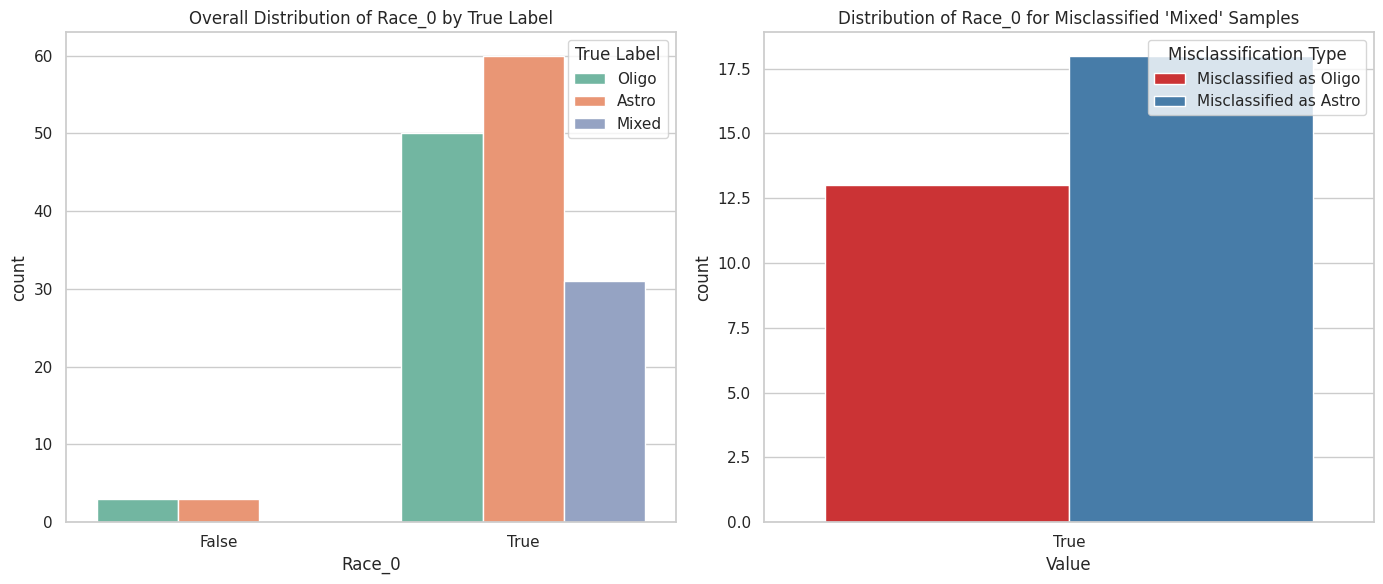

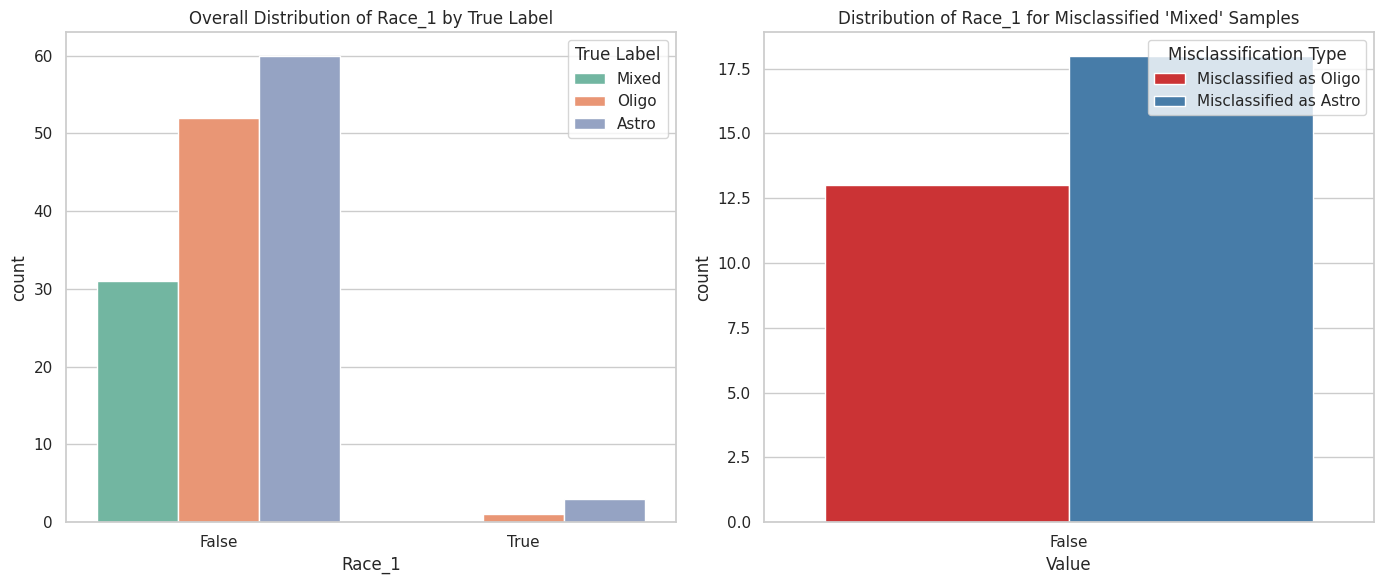

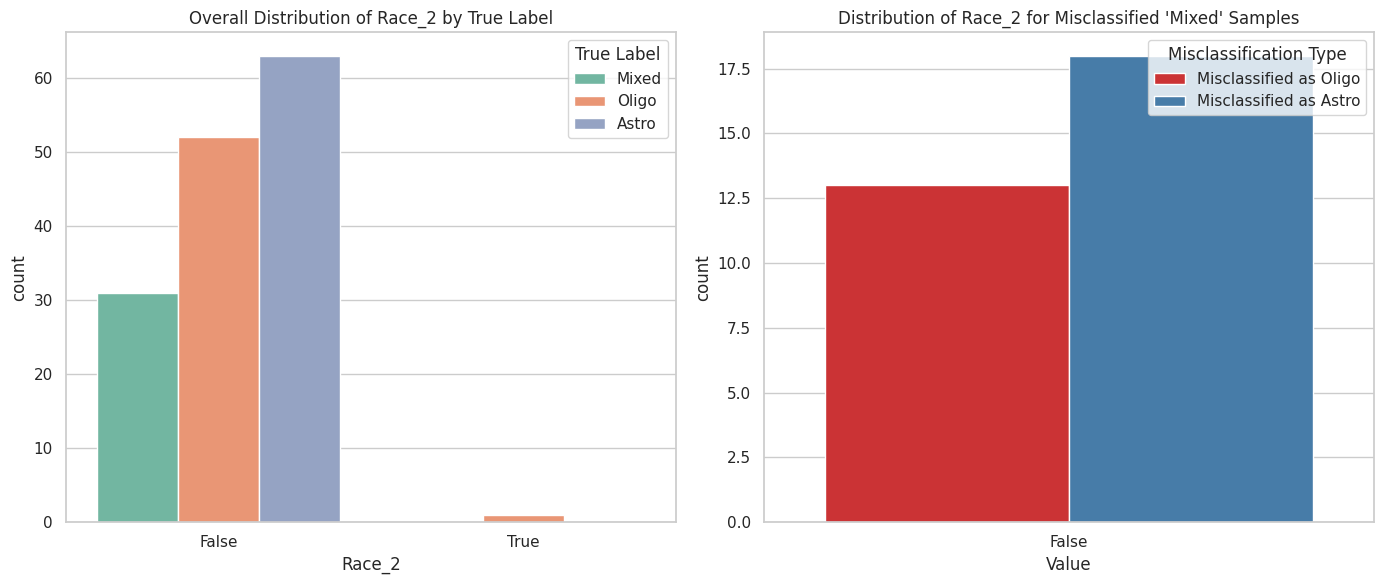

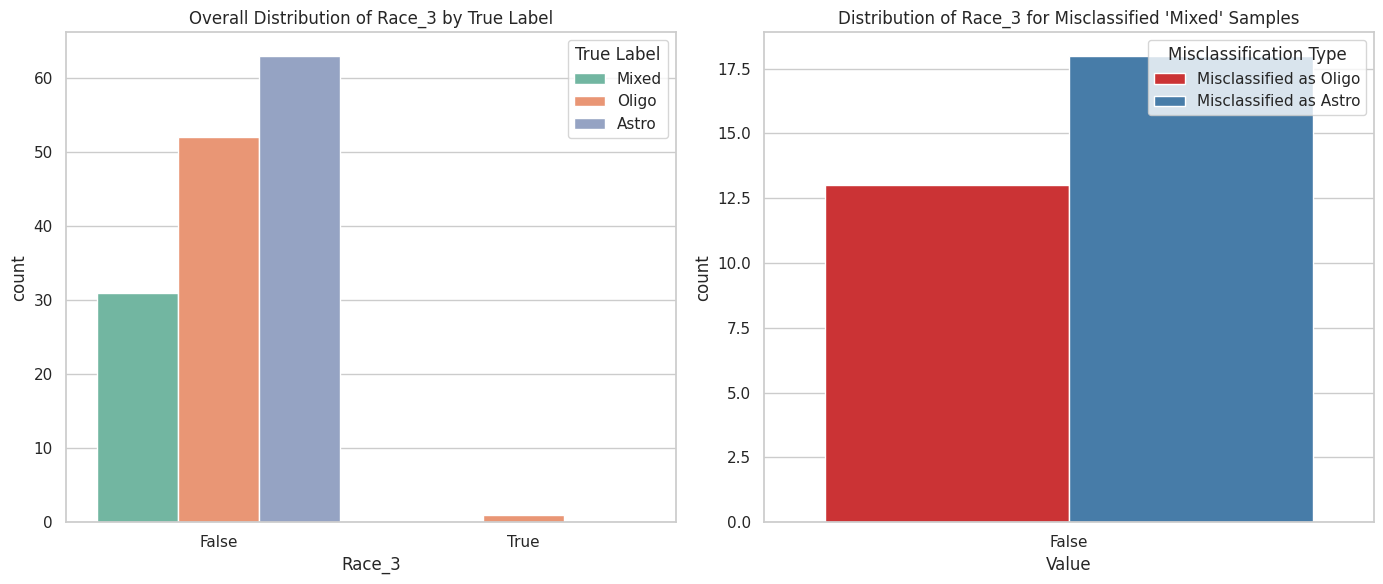

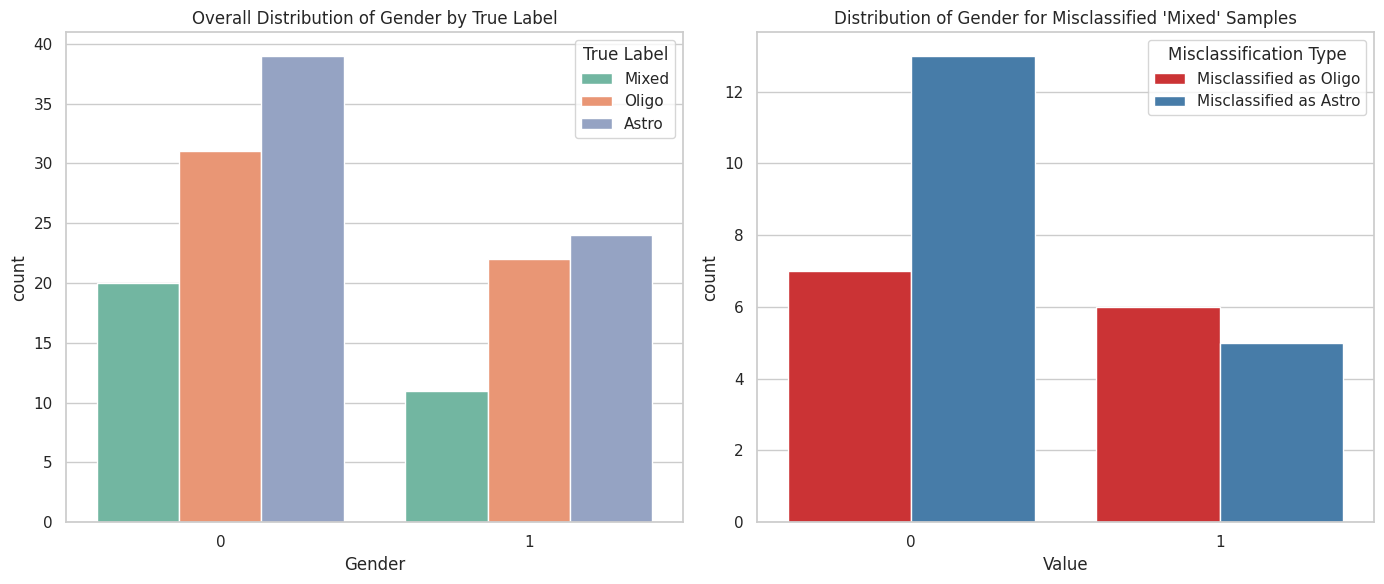

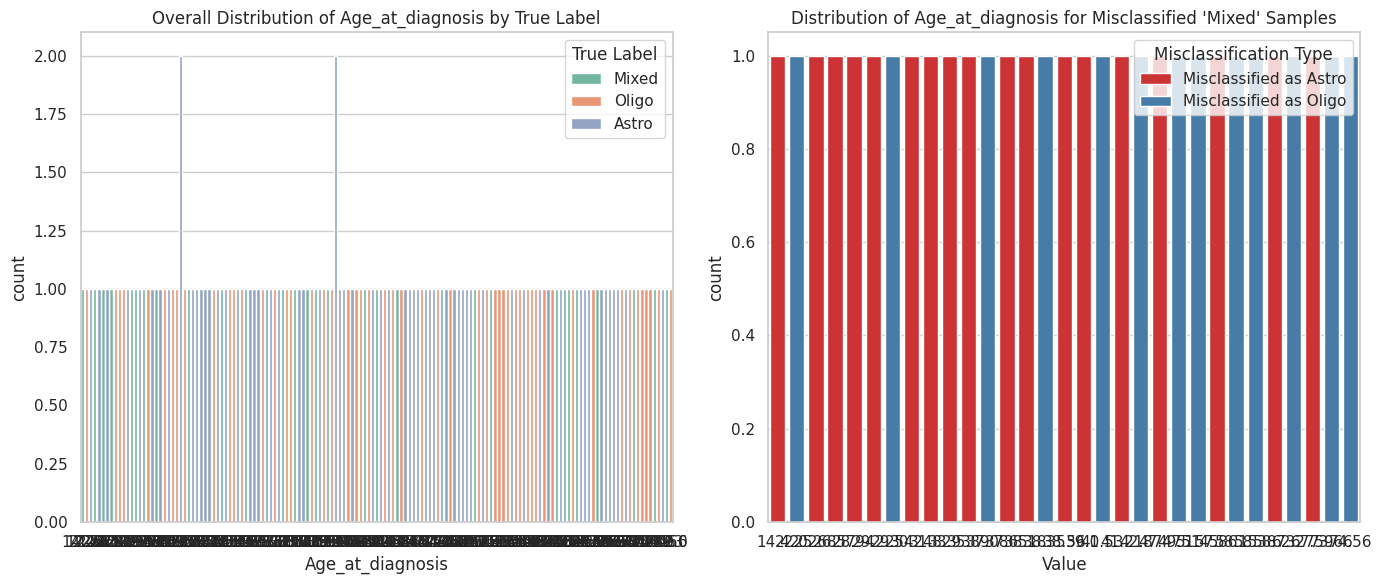

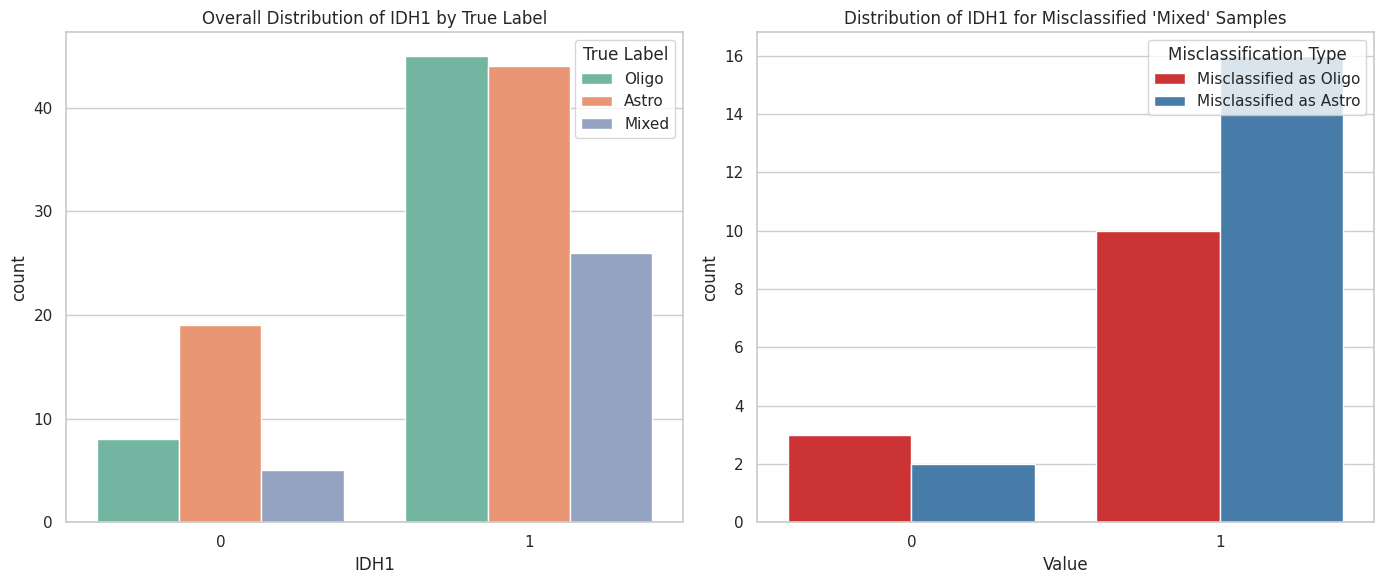

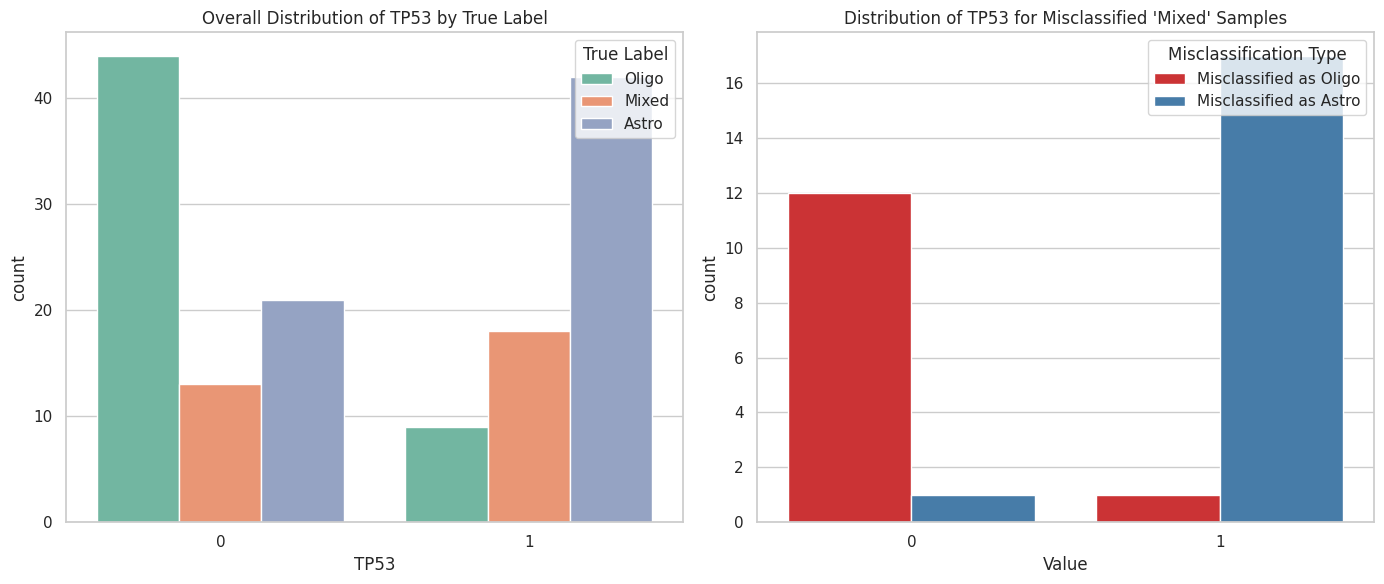

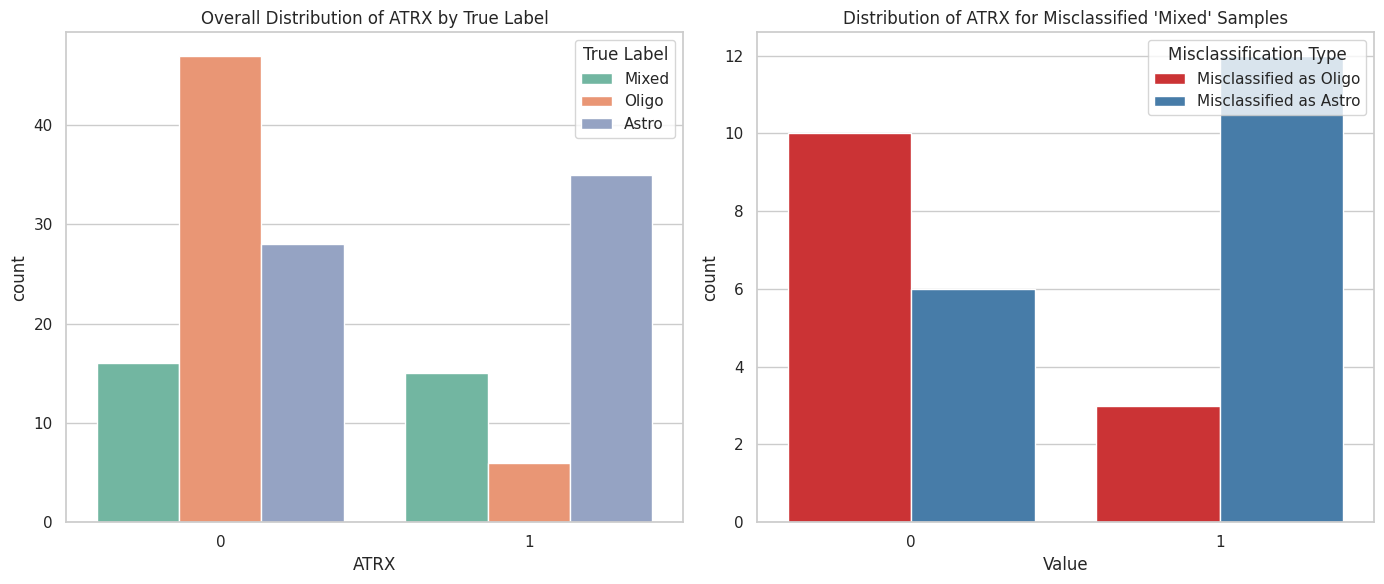

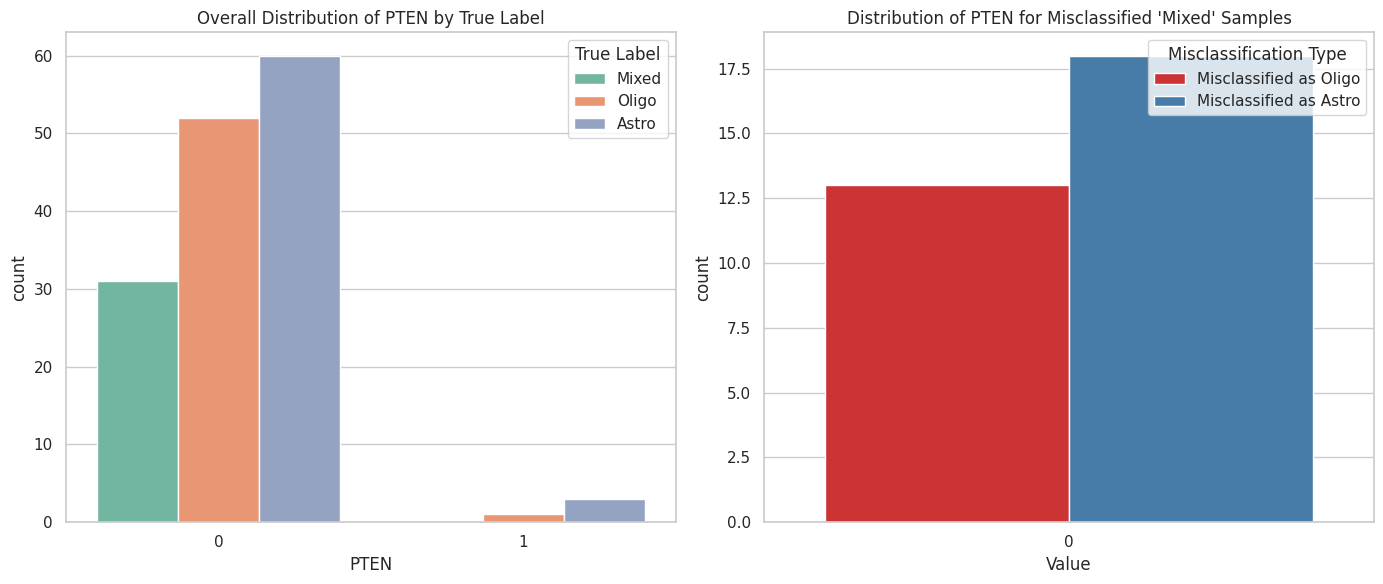

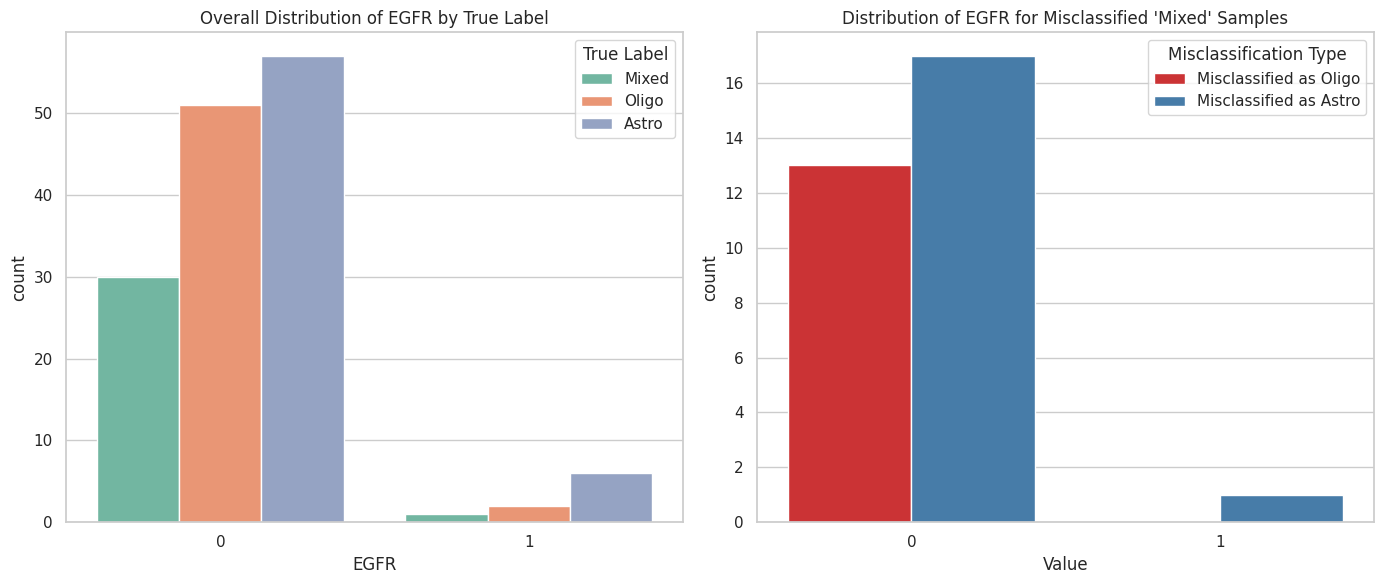

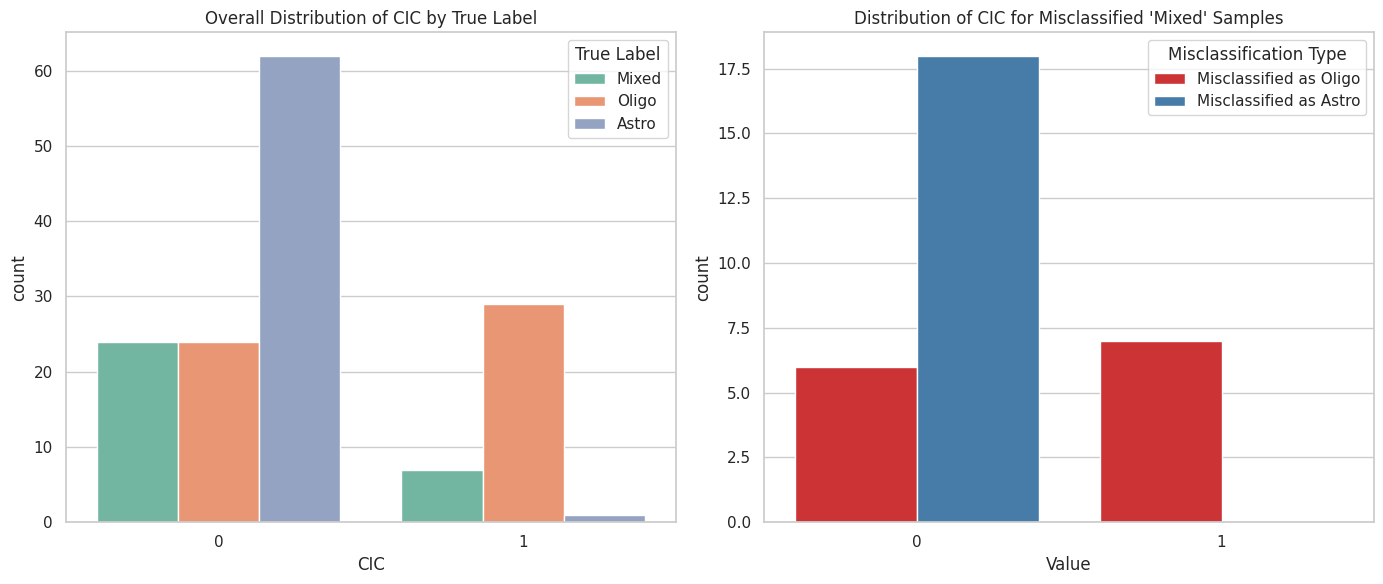

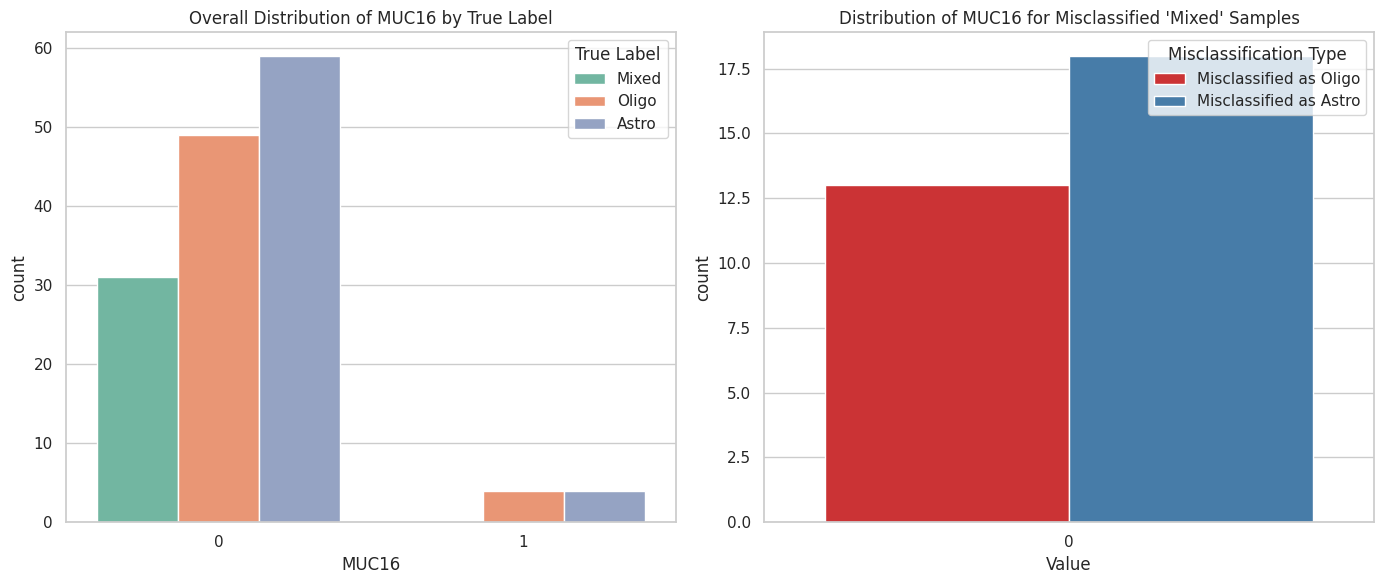

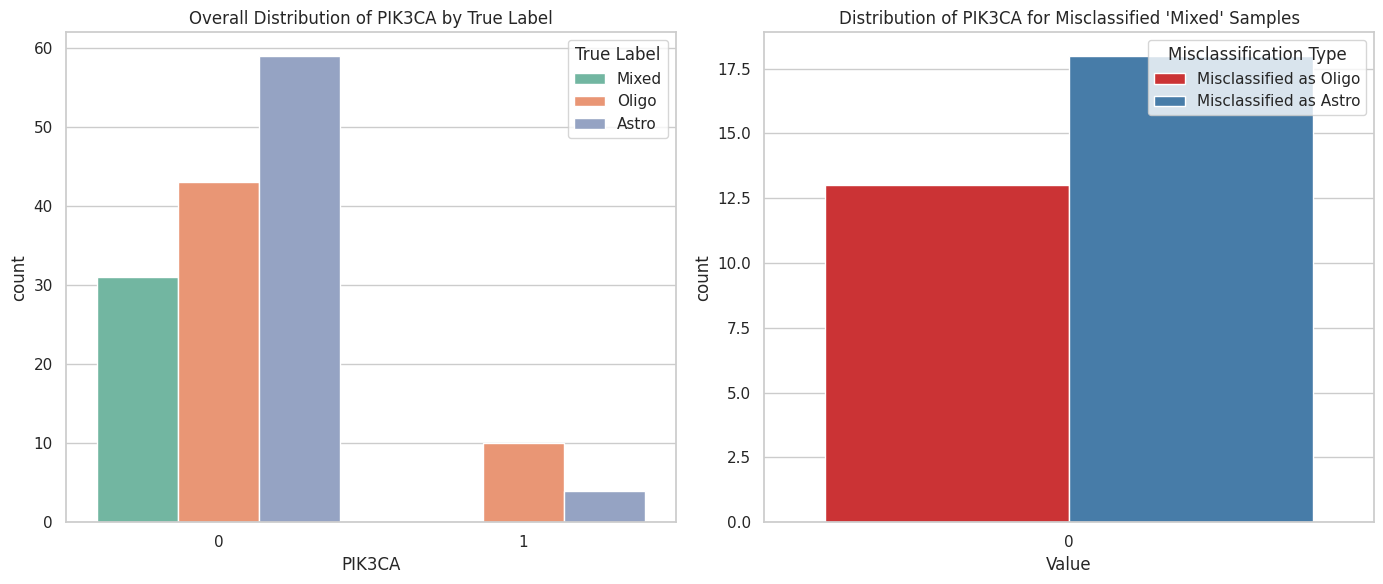

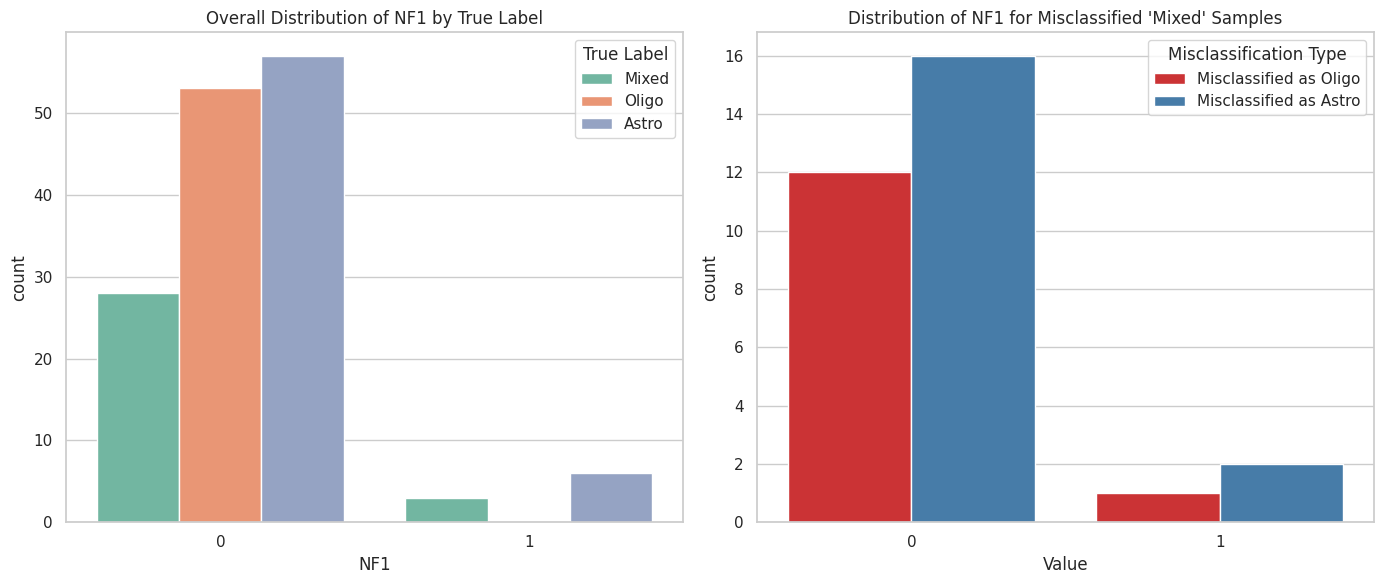

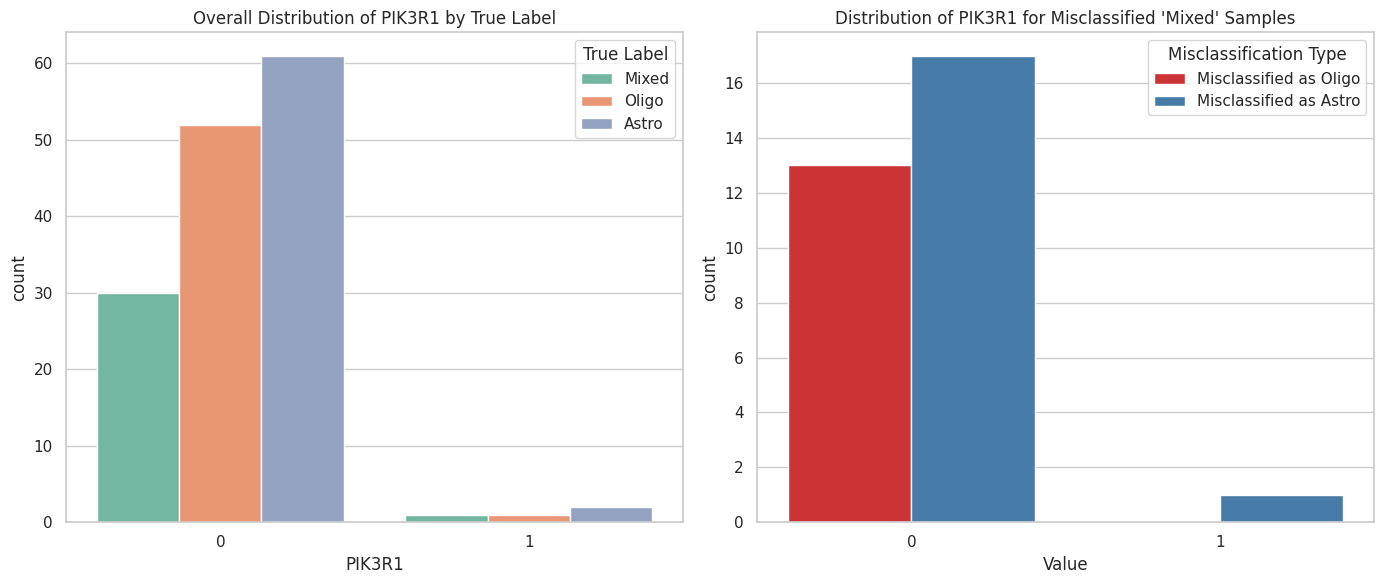

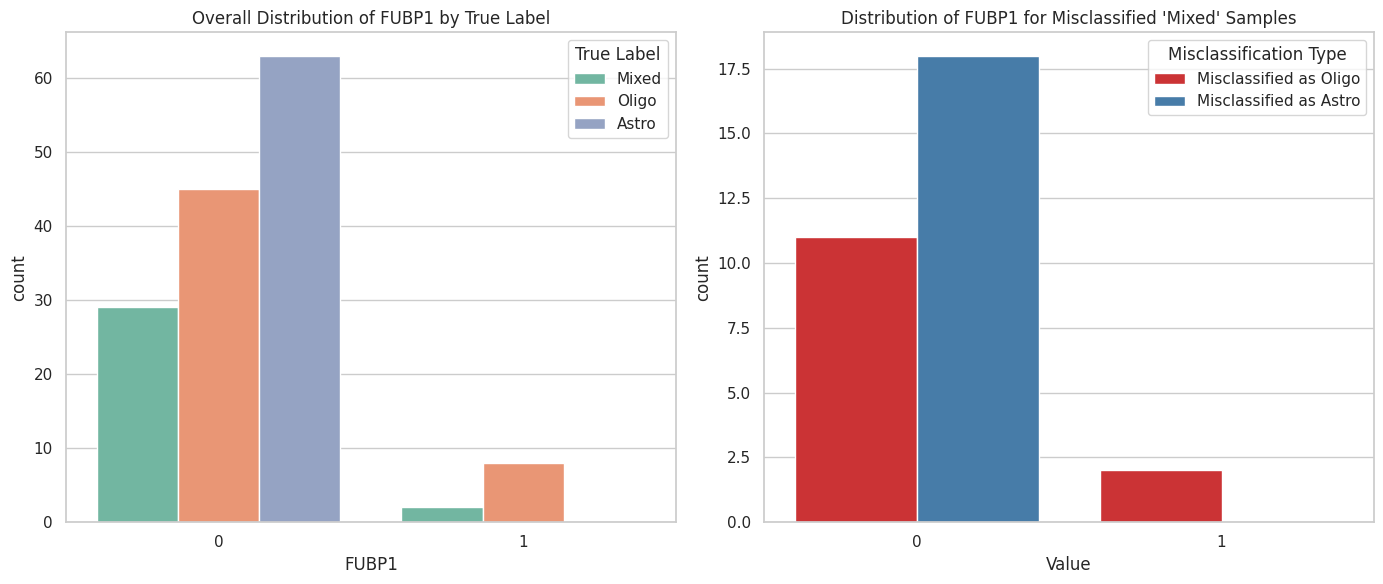

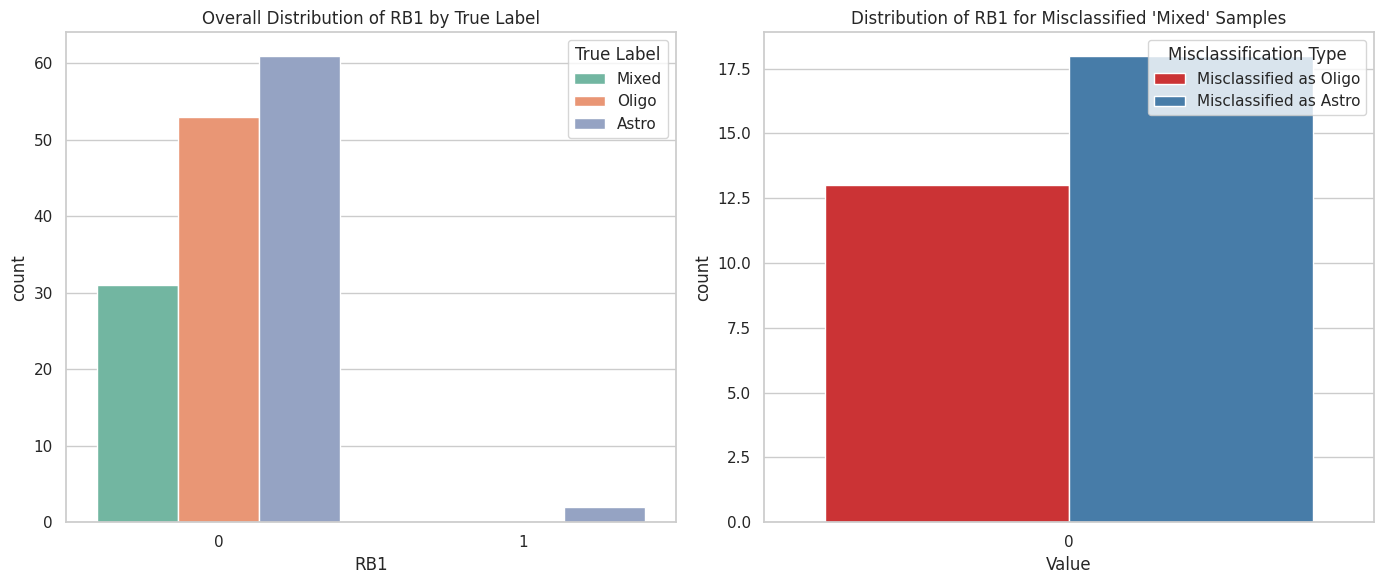

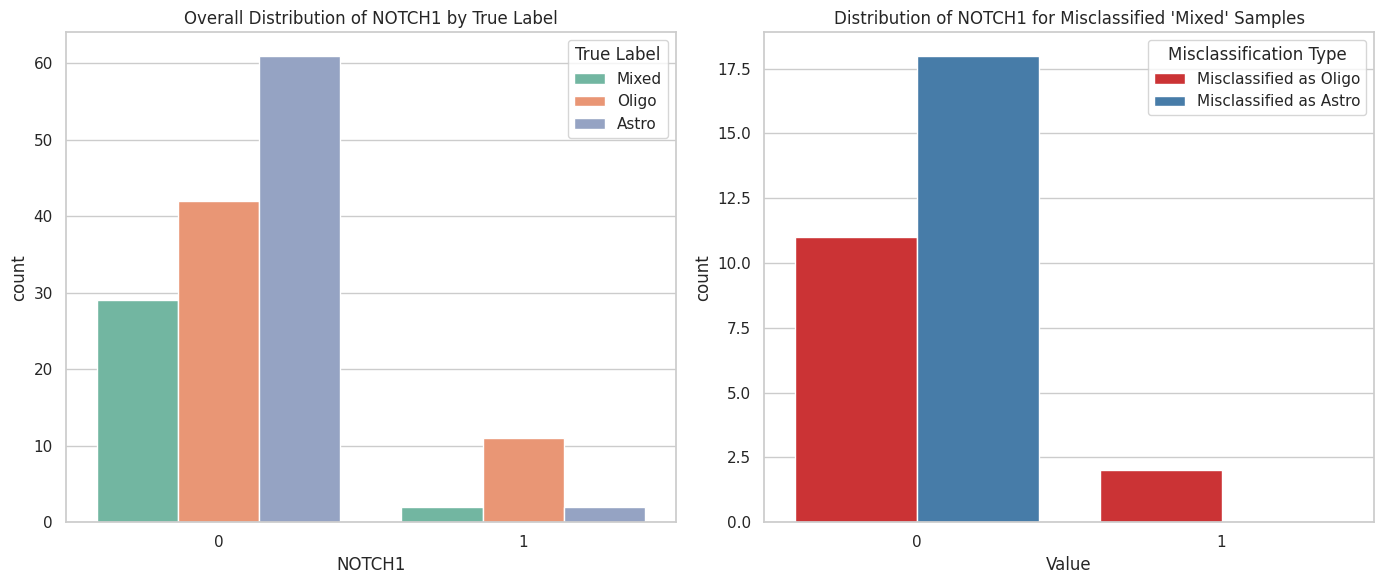

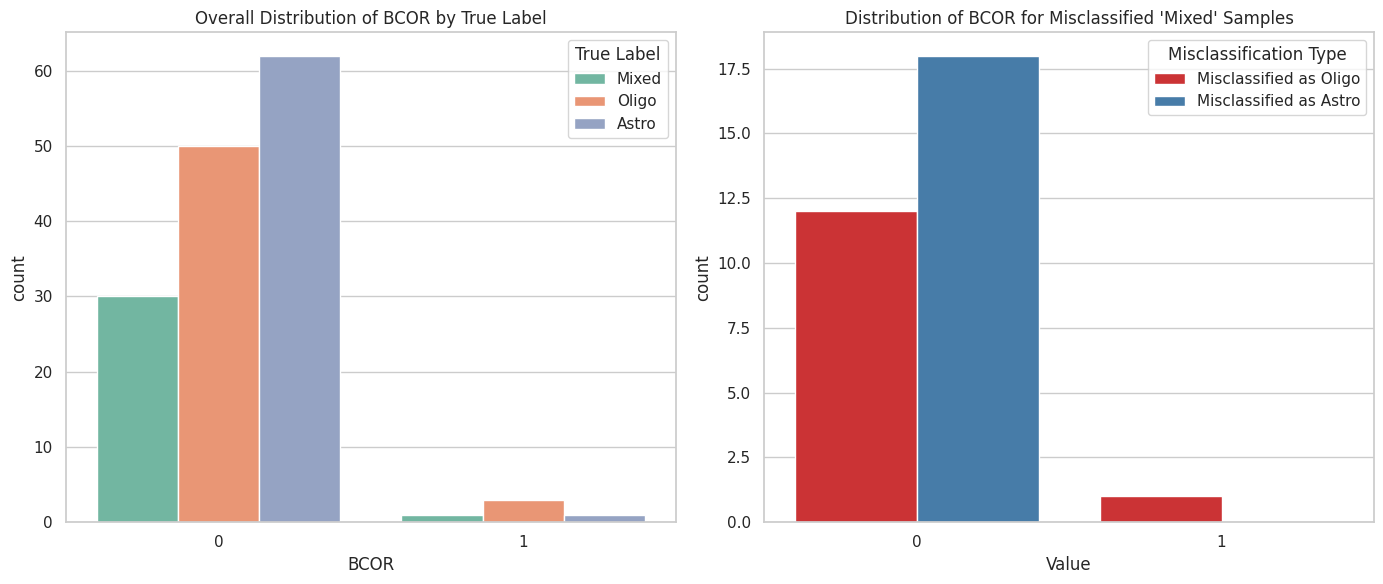

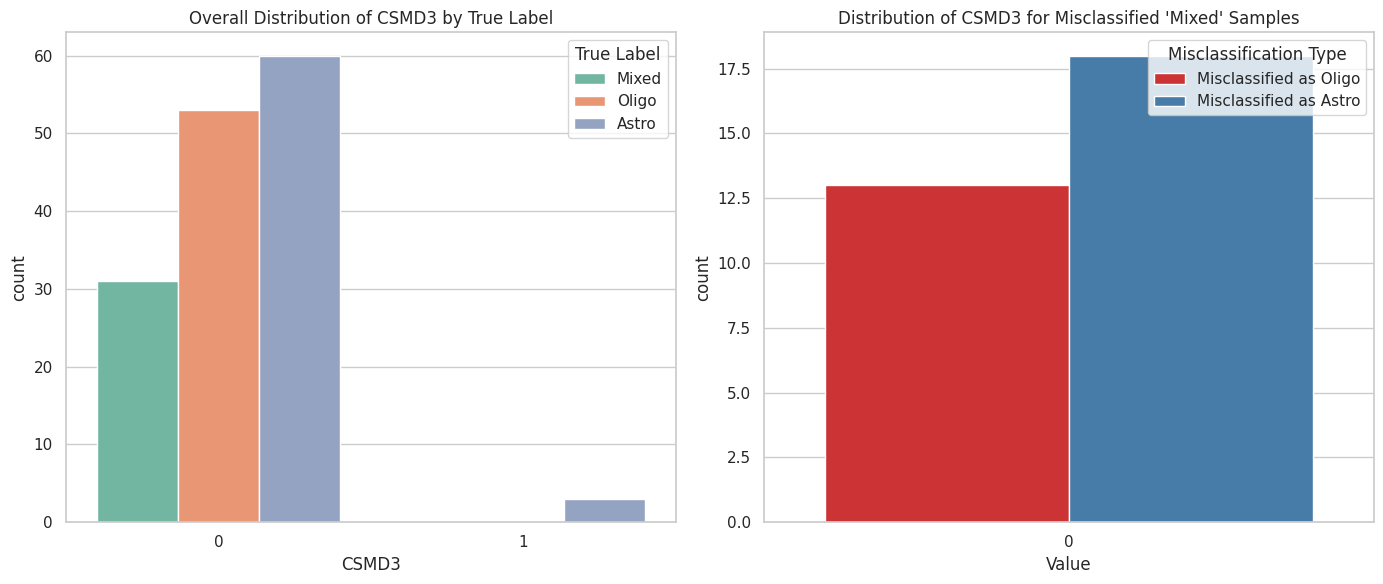

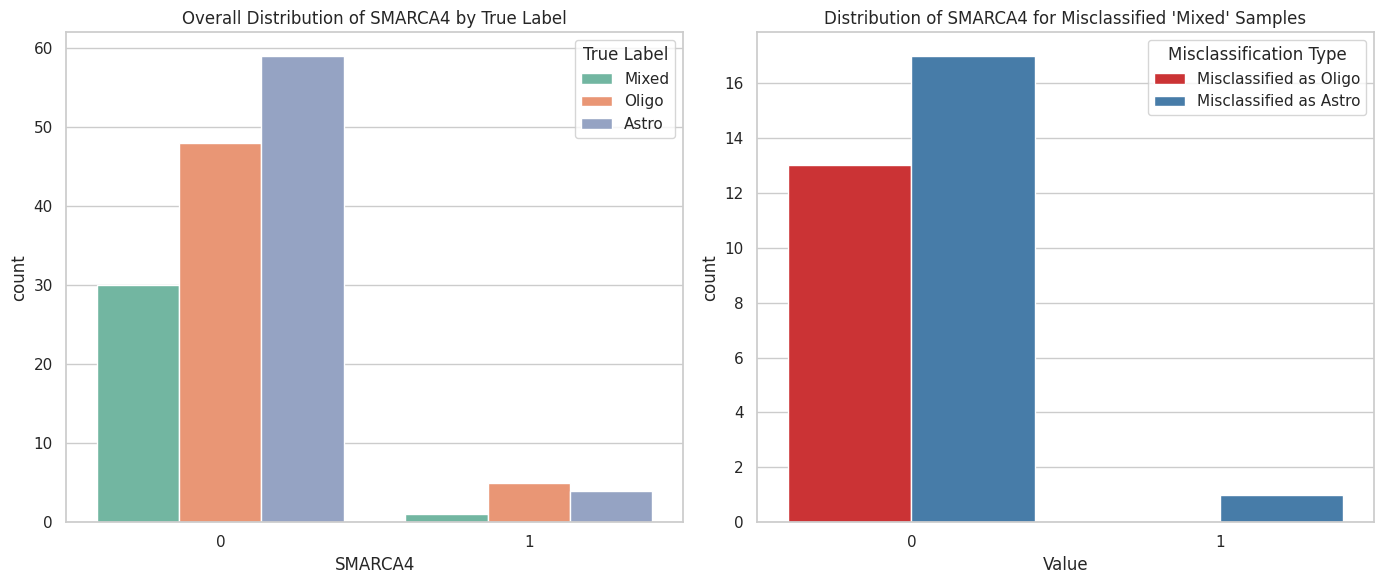

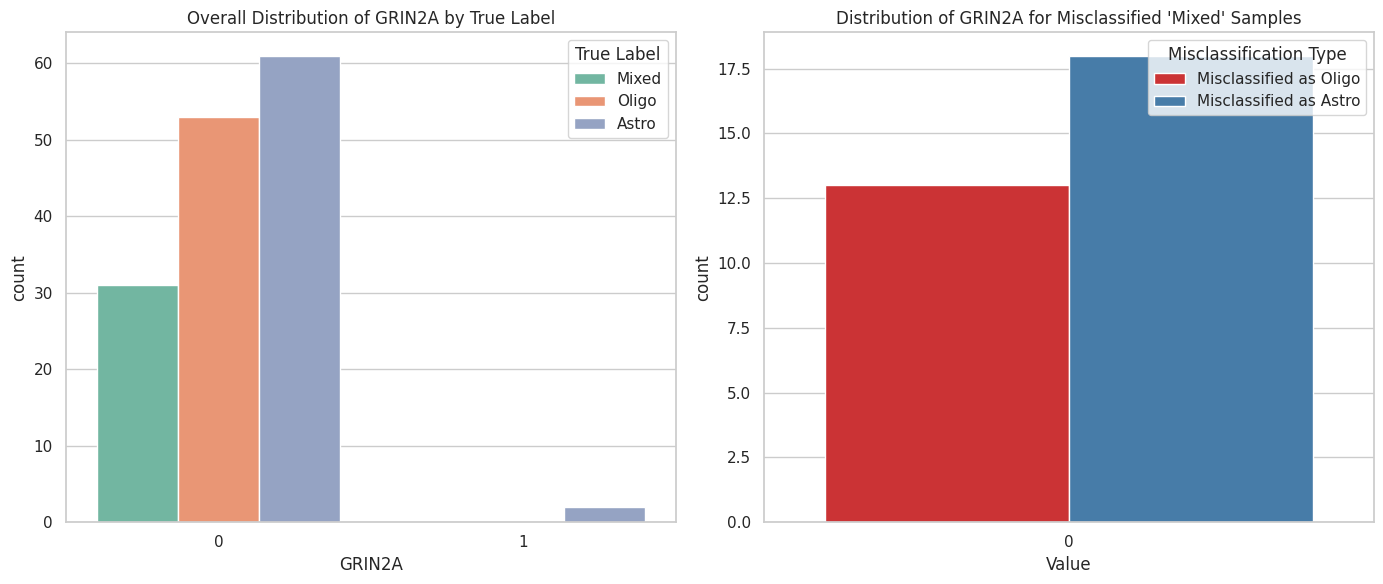

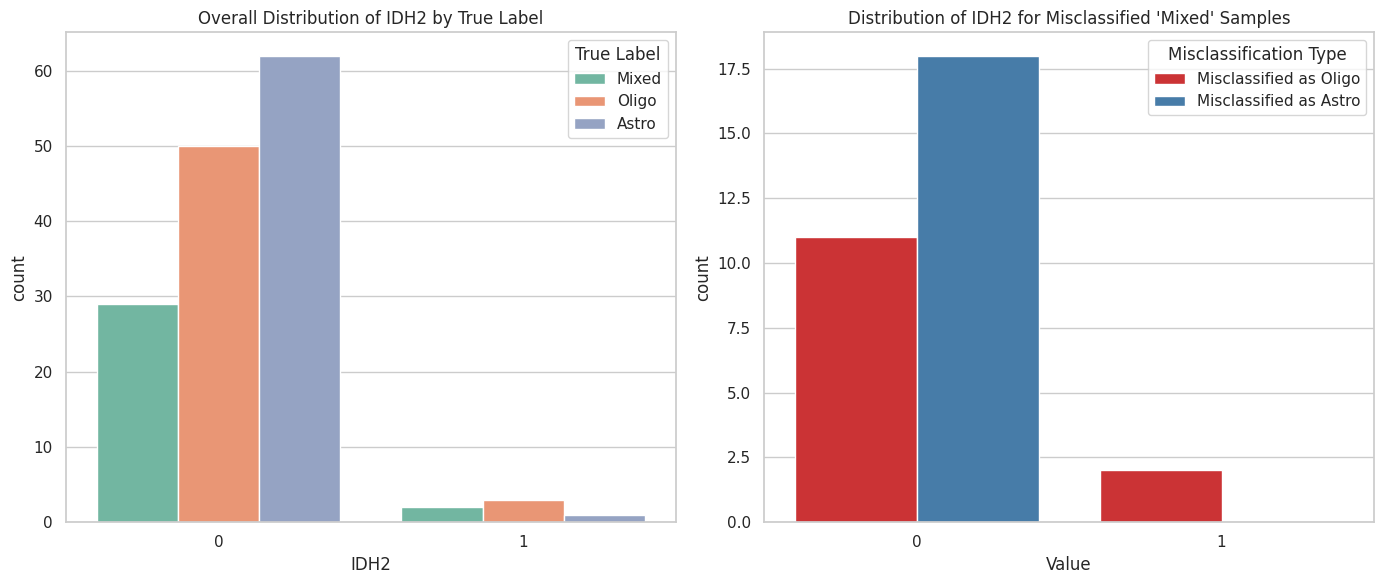

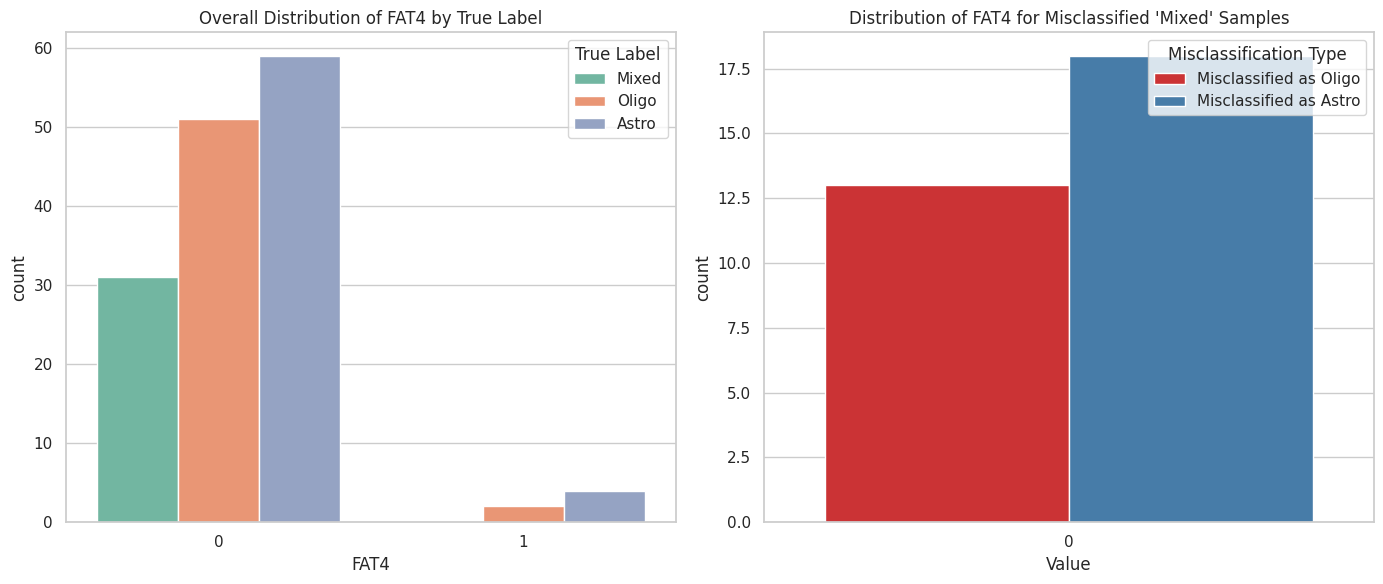

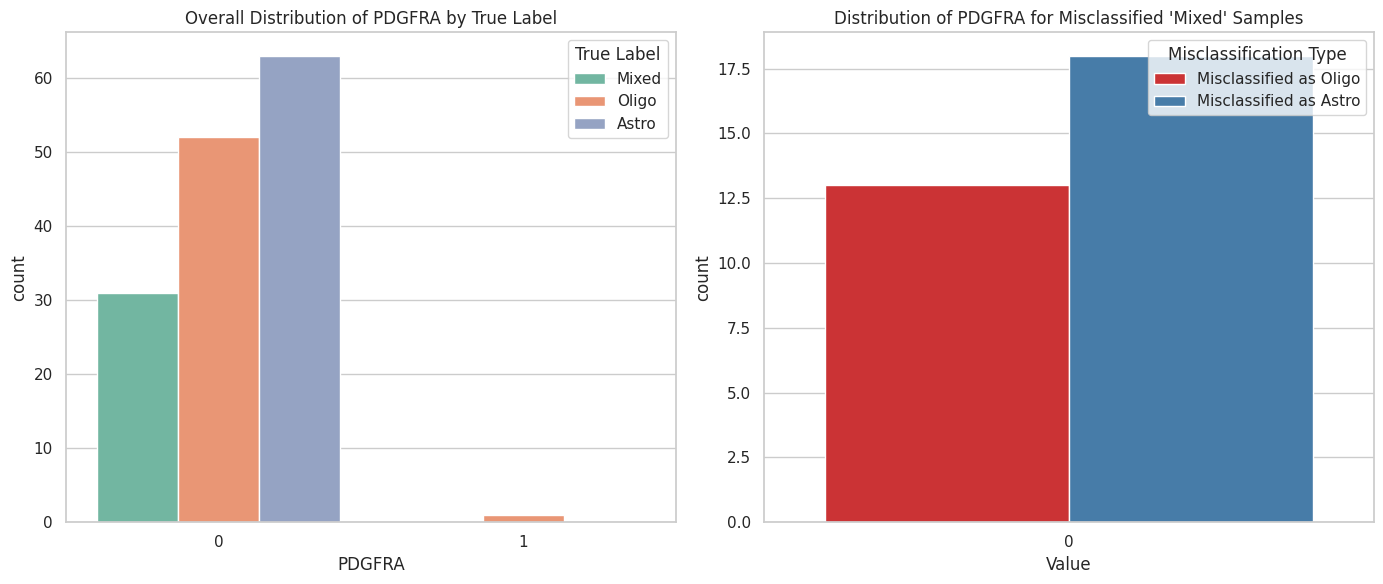

     Race_0  Race_1  Race_2  Race_3  Gender  Age_at_diagnosis  IDH1  TP53  \
5      True   False   False   False       1             29.54     0     0   
33     True   False   False   False       0             49.51     1     0   
53     True   False   False   False       1             37.08     1     0   
56     True   False   False   False       0             38.35     1     0   
59     True   False   False   False       0             22.02     0     0   
69     True   False   False   False       0             62.27     1     0   
88     True   False   False   False       0             51.45     1     1   
91     True   False   False   False       1             58.15     1     0   
94     True   False   False   False       0             58.38     0     0   
96     True   False   False   False       0             42.87     1     0   
107    True   False   False   False       1             74.56     1     0   
115    True   False   False   False       1             40.53     1     0   

In [ ]:
# copying the tesitng data
features = X_testing.copy(deep = True)
true_labels= Y_testing.copy(deep = True)
df = X_testing.copy(deep = True)

df = df.reset_index(drop=True)
true_labels = true_labels.reset_index(drop=True)
df['predicted_label'] = stacking_pred
df['true_label'] = true_labels

misclassified_mixed = df[(df['true_label'] == 'Mixed') & (df['predicted_label'] != 'Mixed')]
misclassified_mixed_Oligo = df[(df['true_label'] == 'Mixed') & (df['predicted_label'] == 'Oligo')]
misclassified_mixed_Astro = df[(df['true_label'] == 'Mixed') & (df['predicted_label'] == 'Astro')]
# Loop through each binary feature
for feature in features.columns:
    plt.figure(figsize=(14, 6))
    # First plot: Overall distribution of the feature by true label
    plt.subplot(1, 2, 1)
    sns.countplot(x=feature, hue='true_label', data=df, palette="Set2")
    plt.title(f'Overall Distribution of {feature} by True Label')
    plt.legend(title='True Label', loc='upper right')
    # Second plot: Distribution of the feature for misclassified 'Mixed' samples
    plt.subplot(1, 2, 2)

    data_for_plot = pd.concat([
        pd.DataFrame({'Label': 'Misclassified as Oligo', 'Value': misclassified_mixed_Oligo[feature]}),
        pd.DataFrame({'Label': 'Misclassified as Astro', 'Value': misclassified_mixed_Astro[feature]})
    ])
    sns.countplot(x='Value', hue='Label', data=data_for_plot, palette="Set1")
    plt.title(f'Distribution of {feature} for Misclassified \'Mixed\' Samples')
    plt.legend(title='Misclassification Type', loc='upper right')

    plt.tight_layout()
    plt.show()


Top 5 Important Features for RF:
CIC: 0.29948674775514156
Age_at_diagnosis: 0.19407388526893382
TP53: 0.12296905846892106
ATRX: 0.06976330850644531
IDH1: 0.058954176374620616


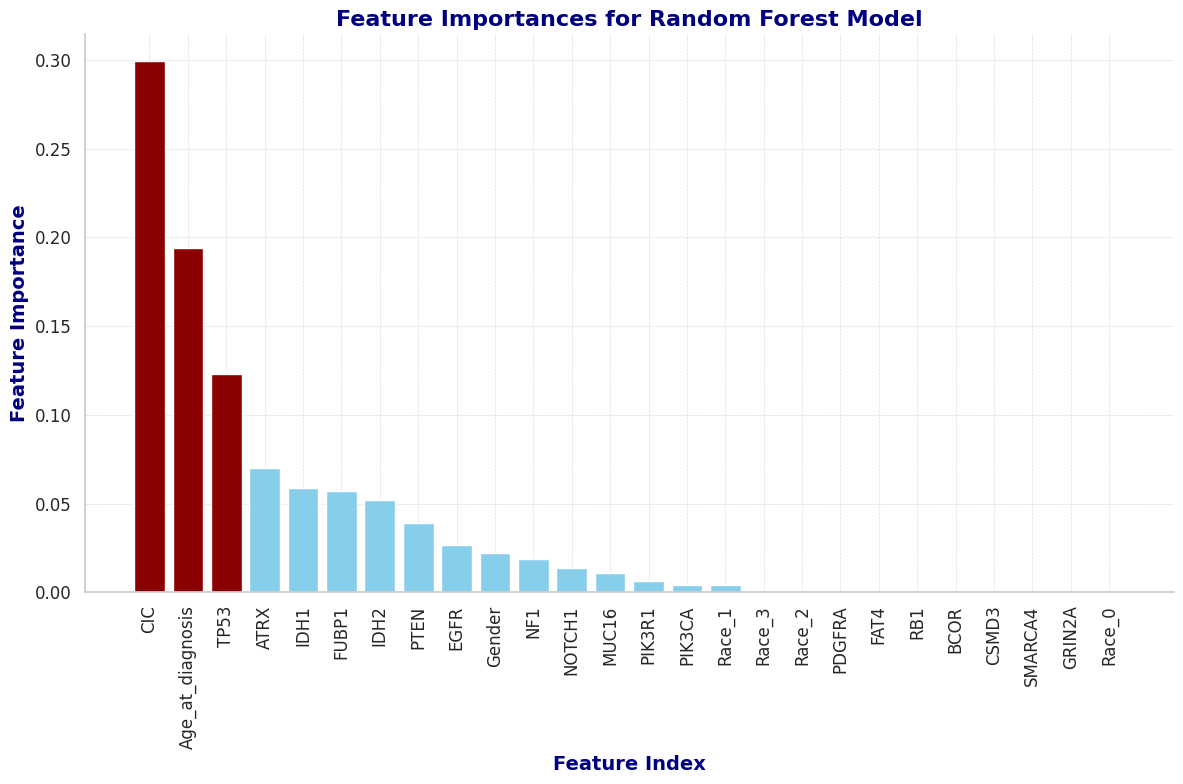


Top 5 Important Features for MLP:
TP53: 0.16851851851851848
CIC: 0.10555555555555551
IDH2: 0.05740740740740735
FUBP1: 0.04629629629629626
Age_at_diagnosis: 0.033333333333333284


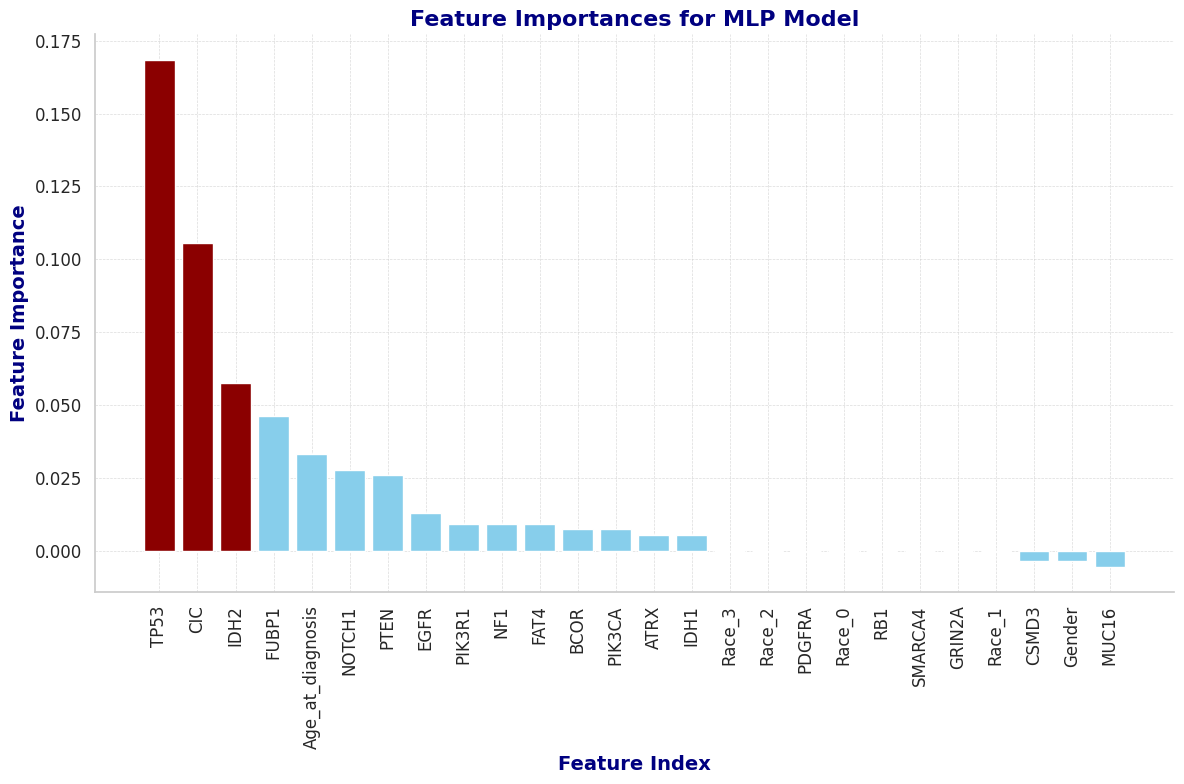

In [ ]:
## Model Feature importances:
# Random Forest feature importances
rf_feature_importances = RfOptimized.feature_importances_

#MLP permuation importance

from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(optimized_mlp, X_testing, Y_testing)

# Extract feature importances
mlp_feature_importances = perm_importance.importances_mean


feature_names = features.columns.tolist()
feature_names = np.array(feature_names)
sorted_idx_rf = np.argsort(rf_feature_importances)[::-1]

# Print the top 3 most important features
print("RF")
for idx in sorted_idx_rf[:5]:
    print(f"{feature_names[idx]}: {rf_feature_importances[idx]}")

# Plotting
plt.figure(figsize=(12, 8))
colors = ['skyblue' if i >= 3 else 'darkred' for i in range(len(rf_feature_importances))]
bars = plt.bar(range(len(rf_feature_importances)), rf_feature_importances[sorted_idx_rf], color=colors)
plt.xlabel('Feature Index', fontsize=14, fontweight='bold', color='navy')
plt.ylabel('Feature Importance', fontsize=14, fontweight='bold', color='navy')
plt.title('Feature Importances for Random Forest Model', fontsize=16, fontweight='bold', color='navy')
tick_labels = [feature_names[idx] if idx < len(feature_names) else f"Feature_{idx}" for idx in sorted_idx_rf]
plt.xticks(range(len(rf_feature_importances)), tick_labels, rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.gca().set_axisbelow(True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()


sorted_idx_mlp = np.argsort(mlp_feature_importances)[::-1]

# Print the top 5 most important features
print("MLP:")
for idx in sorted_idx_mlp[:5]:
    print(f"{feature_names[idx]}: {mlp_feature_importances[idx]}")


# Plotting
plt.figure(figsize=(12, 8))
colors = ['skyblue' if i >= 3 else 'darkred' for i in range(len(mlp_feature_importances))]
bars = plt.bar(range(len(mlp_feature_importances)), mlp_feature_importances[sorted_idx_mlp], color=colors)
plt.xlabel('Feature Index', fontsize=14, fontweight='bold', color='navy')
plt.ylabel('Feature Importance', fontsize=14, fontweight='bold', color='navy')
plt.title('Feature Importances for MLP Model', fontsize=16, fontweight='bold', color='navy')
tick_labels = [feature_names[idx] if idx < len(feature_names) else f"Feature_{idx}" for idx in sorted_idx_mlp]
plt.xticks(range(len(mlp_feature_importances)), tick_labels, rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.gca().set_axisbelow(True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()



# Unsupervised Learning & Clustering

In [ ]:

# making labels into dataframe
labels_true = pd.DataFrame(labels)
#print(labels_true)


label_encoder = LabelEncoder()
labels_true['Primary_Diagnosis_numerical'] = label_encoder.fit_transform(labels_true['Primary_Diagnosis'])



In [ ]:
# PCA
#Standardizing Age_at_diagnosis
scaler = StandardScaler()
lgg_data['Age_at_diagnosis']= scaler.fit_transform(lgg_data[['Age_at_diagnosis']])

pca = PCA()
# Fit PCA on the dataset
pca.fit(lgg_data)
# Transform the dataset
features_pca = pca.transform(lgg_data)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

#  95% variance
n_components_95 = np.where(cumulative_variance >= 0.95)[0][0] + 1

print(f" 95% of variance: {n_components_95}") #it/s 17

pca_optimized = PCA(n_components=15)

# Fit and transform the dataset with the optimized PCA
features_pca_optimized = pca_optimized.fit_transform(lgg_data)

lgg_data_pca = pd.DataFrame(features_pca_optimized, columns=['PC1', 'PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11','PC12','PC13','PC14', 'PC15'])


 95% of variance: 17


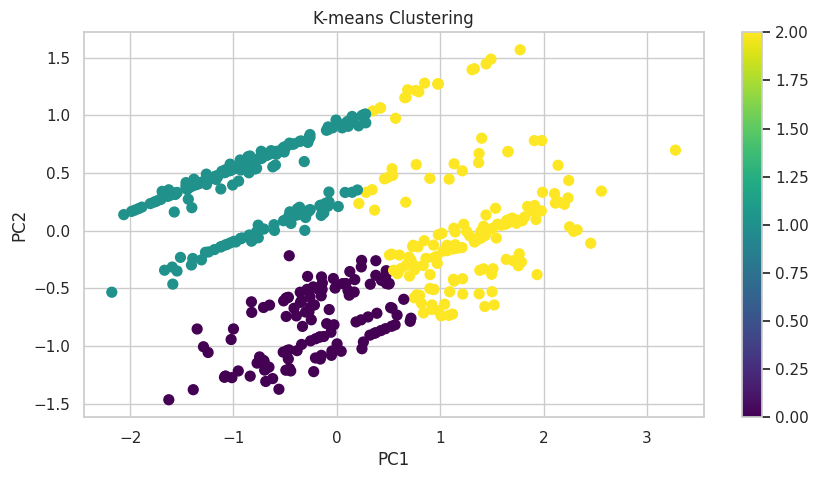

Adjusted Rand Index - KMeans: 0.09126838030139152


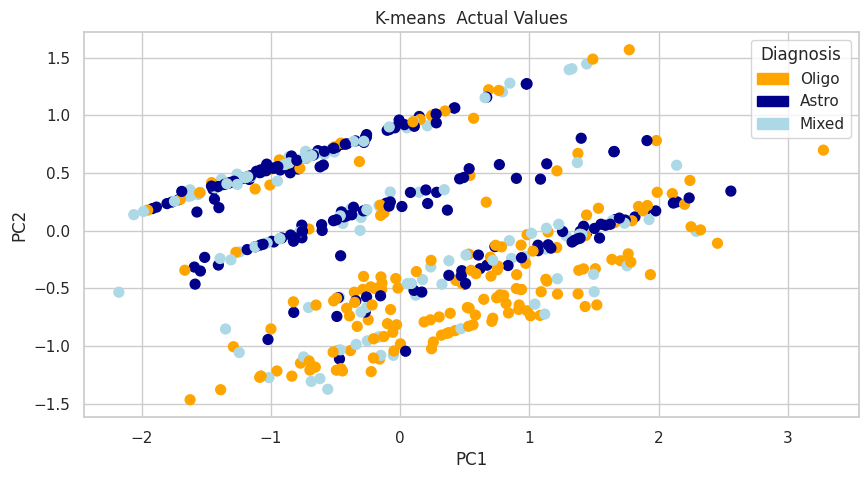

In [ ]:
## K_means

warnings.filterwarnings('ignore')

# optimization
# wcss = []
# for i in range(1, 5): # Testing 1 to 10 clusters
#     kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
#     kmeans.fit(features_pca_optimized)
#     wcss.append(kmeans.inertia_)

# # line graph
# plt.figure(figsize=(10,5))
# plt.plot(range(1, 5), wcss, marker='o', linestyle='--')
# plt.title('Elbow Method')
# plt.xlabel('Number of clusters')
# plt.ylabel('WCSS') # Within cluster sum of squares
# plt.show()

kmeans_optimal = KMeans(n_clusters=3, init='k-means++', random_state=42)
kmeans_clusters = kmeans_optimal.fit_predict(features_pca_optimized)

# Adding cluster info to the dataset
lgg_data_pca['KMeans_Cluster'] = kmeans_clusters

plt.figure(figsize=(10, 5))
plt.scatter(lgg_data_pca['PC1'], lgg_data_pca['PC2'], c=lgg_data_pca['KMeans_Cluster'], s=50, cmap='viridis')
plt.title('K-means Clustering')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.show()

# ARI
true_labels = labels.values
ari_kmeans = adjusted_rand_score(true_labels, kmeans_clusters)


# Printing the scores for comparison
print("Adjusted Rand Index - KMeans:", ari_kmeans)

#labels_numeric = pd.Categorical(labels).codes
plt.figure(figsize=(10, 5))
label_color_map = {'Oligo': 'orange', 'Astro': 'darkblue', 'Mixed': 'lightblue'}
colors = labels_true['Primary_Diagnosis'].map(label_color_map)
scatter = plt.scatter(lgg_data_pca['PC1'], lgg_data_pca['PC2'], c=colors, s=50, cmap='viridis')
plt.title('K-means  Actual Values')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in label_color_map.items()]
plt.legend(handles=legend_handles, title="Diagnosis")
plt.show()


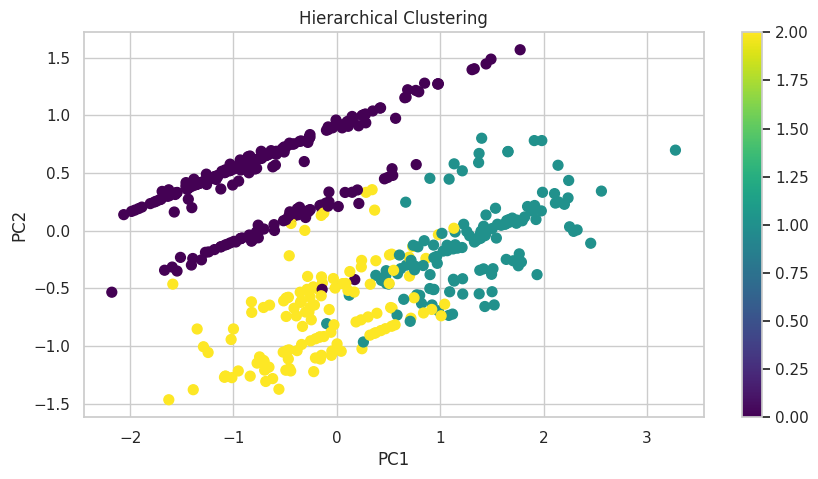

Hierarchical ARI: 0.09669570863879569


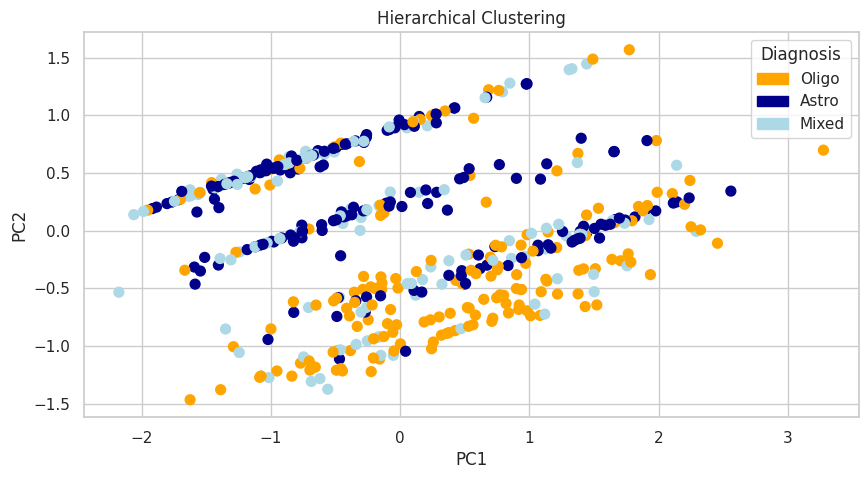

In [ ]:
#Hierarchal Clustering
hierarchical = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
hierarchical_clusters = hierarchical.fit_predict(features_pca_optimized)

# Adding cluster info to the PCA dataframe

lgg_data_pca['Hierarchical_Cluster'] = hierarchical_clusters

# Plotting Hierarchical clusters
plt.figure(figsize=(10, 5))
plt.scatter(lgg_data_pca['PC1'], lgg_data_pca['PC2'], c=lgg_data_pca['Hierarchical_Cluster'], s=50, cmap='viridis')
plt.title('Hierarchical Clustering')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar()
plt.show()

#ARI
ari_hierarchical = adjusted_rand_score(true_labels, hierarchical_clusters)
print( "Hierarchical ARI:", ari_hierarchical)


#TRUE
plt.figure(figsize=(10, 5))
scatter = plt.scatter(lgg_data_pca['PC1'], lgg_data_pca['PC2'], c=colors, s=50, cmap='viridis')
plt.title('Hierarchical Clustering')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in label_color_map.items()]
plt.legend(handles=legend_handles, title="Diagnosis")
plt.show()


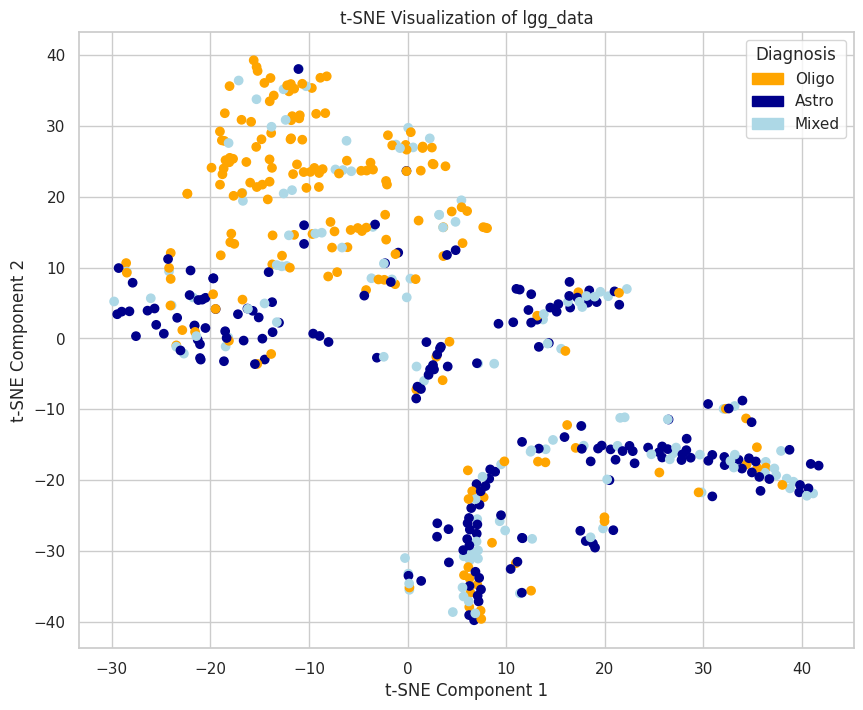

In [ ]:
#Tsne
# Initialize t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=20, n_iter=1000, learning_rate = 1000)

# Apply t-SNE to the standardized lgg
features_tsne = tsne.fit_transform(lgg_data)
tsne_df = pd.DataFrame(features_tsne, columns=['tSNE1', 'tSNE2'])

plt.figure(figsize=(10, 8))
plt.scatter(tsne_df['tSNE1'], tsne_df['tSNE2'], c=colors)

plt.title('t-SNE Visualization of lgg_data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in label_color_map.items()]
plt.legend(handles=legend_handles, title="Diagnosis")
plt.show()


Adjusted Rand Index (ARI): 0.16168013993373428


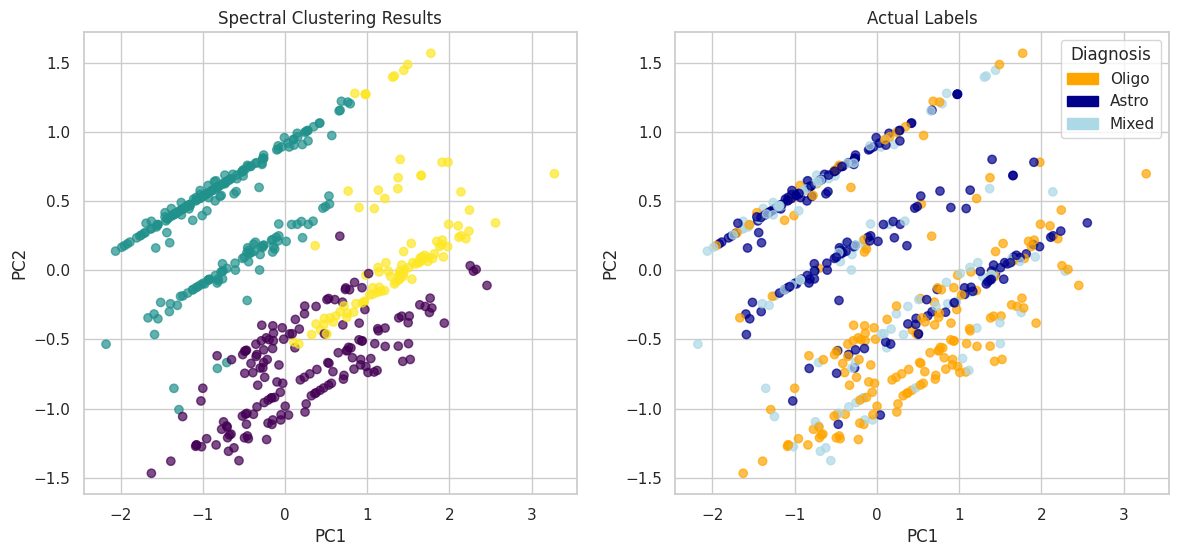

In [ ]:
#Spectral clustering

spectral = SpectralClustering(n_clusters=3, affinity='rbf', assign_labels='discretize', random_state=42)
clusters = spectral.fit_predict(lgg_data)

ari_score_spectral = adjusted_rand_score(labels, clusters)
print(f"Adjusted Rand Index (ARI): {ari_score_spectral}")


lgg_data_pca["True_Label"] = labels
lgg_data_pca['Cluster'] = clusters

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(lgg_data_pca['PC1'], lgg_data_pca['PC2'], c=lgg_data_pca['Cluster'], cmap='viridis', alpha=0.7)
plt.title('Spectral Clustering Results')
plt.xlabel('PC1')
plt.ylabel('PC2')

# Plotting the actual labels for comparison
plt.subplot(1, 2, 2)
plt.scatter(lgg_data_pca['PC1'], lgg_data_pca['PC2'], c=colors, cmap='viridis', alpha=0.7)
plt.title('Actual Labels')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in label_color_map.items()]
plt.legend(handles=legend_handles, title="Diagnosis")
plt.show()

In [ ]:
# Clustering without PCA (Normal dataset - all features)
spectral_standard = SpectralClustering(n_clusters=3, affinity='rbf', assign_labels='discretize', random_state=42)
clusters_standard = spectral_standard.fit_predict(lgg_data)
ari_score_spectral_standard = adjusted_rand_score(labels_true["Primary_Diagnosis_numerical"].values, clusters_standard)
print(f"Adjusted Rand Index (ARI): {ari_score_spectral_standard}")

hierarchical_standard = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
hierarchical_clusters_standard = hierarchical_standard.fit_predict(lgg_data)
ari_hierarchical_standard = adjusted_rand_score(labels_true["Primary_Diagnosis_numerical"].values, hierarchical_clusters_standard)
print( "Hierarchical ARI:", ari_hierarchical_standard)

kmeans_optimal_standard = KMeans(n_clusters=3, init='k-means++', random_state=42)
kmeans_clusters_standard = kmeans_optimal_standard.fit_predict(lgg_data)
ari_kmeans_standard = adjusted_rand_score(labels_true["Primary_Diagnosis_numerical"].values, kmeans_clusters_standard)
# Silhouette Score (using the reduced data from PCA for the silhouette score calculation)
print( "KMeans ARI:", ari_kmeans_standard)


Adjusted Rand Index (ARI): 0.16168013993373428
Hierarchical ARI: 0.08989254781076476
KMeans ARI: 0.09126838030139152


In [ ]:
# Clustering without PCA, without Age, Race, Gender

lgg_data_short = lgg_data.drop(columns = ["Race_0","Race_1", "Race_2", "Race_3", "Gender","Age_at_diagnosis"])

spectral_short = SpectralClustering(n_clusters=3, affinity='rbf', assign_labels='discretize', random_state=42)
clusters_short = spectral_short.fit_predict(lgg_data_short)

ari_score_spectral_short = adjusted_rand_score(labels_true["Primary_Diagnosis_numerical"].values, clusters_short)
print(f"Adjusted Rand Index (ARI): {ari_score_spectral_short}")


hierarchical_short = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
hierarchical_clusters_short = hierarchical_short.fit_predict(lgg_data_short)
ari_hierarchical_short = adjusted_rand_score(labels_true["Primary_Diagnosis_numerical"].values, hierarchical_clusters_short)
print( "Hierarchical ARI:", ari_hierarchical_short)

kmeans_optimal_short = KMeans(n_clusters=3, init='k-means++', random_state=42)
kmeans_clusters_short = kmeans_optimal_short.fit_predict(lgg_data_short)
ari_kmeans_short = adjusted_rand_score(labels_true["Primary_Diagnosis_numerical"].values, kmeans_clusters_short)
# Silhouette Score (using the reduced data from PCA for the silhouette score calculation)
print( "KMeans ARI:", ari_kmeans_short)


Adjusted Rand Index (ARI): 0.17063302744120193
Hierarchical ARI: 0.11512927291011274
KMeans ARI: 0.16347177835120724


In [ ]:
##Clustering With PCA Without Race, age, gender

pca_short = PCA()
# Fit PCA on the dataset
pca_short.fit(lgg_data_short)
# Transform the dataset
features_pca_short = pca_short.transform(lgg_data_short)

spectral_short_PCA = SpectralClustering(n_clusters=3, affinity='rbf', assign_labels='discretize', random_state=42)
clusters_short_PCA = spectral_short_PCA.fit_predict(features_pca_short)

ari_score_spectral_short_PCA = adjusted_rand_score(labels_true["Primary_Diagnosis_numerical"].values, clusters_short_PCA)
print(f"Adjusted Rand Index (ARI): {ari_score_spectral_short_PCA}")


hierarchical_short_PCA = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
hierarchical_clusters_short_PCA = hierarchical_short_PCA.fit_predict(features_pca_short)
ari_hierarchical_short_PCA = adjusted_rand_score(labels_true["Primary_Diagnosis_numerical"].values, hierarchical_clusters_short_PCA)
print( "Hierarchical ARI:", ari_hierarchical_short_PCA)

kmeans_optimal_short_PCA = KMeans(n_clusters=3, init='k-means++', random_state=42)
kmeans_clusters_short_PCA = kmeans_optimal_short_PCA.fit_predict(features_pca_short)
ari_kmeans_short_PCA = adjusted_rand_score(labels_true["Primary_Diagnosis_numerical"].values, kmeans_clusters_short_PCA)
print( "KMeans ARI:", ari_kmeans_short_PCA)


Adjusted Rand Index (ARI): 0.17063302744120193
Hierarchical ARI: 0.12873864222693993
KMeans ARI: 0.16347177835120724


In [ ]:
#clustering with PCA with everything included
spectral_standard_PCA = SpectralClustering(n_clusters=3, affinity='rbf', assign_labels='discretize', random_state=42)
clusters_standard_PCA = spectral_standard_PCA.fit_predict(features_pca_optimized)

ari_score_spectral_Standard_PCA = adjusted_rand_score(labels_true["Primary_Diagnosis_numerical"].values, clusters_standard_PCA)
print(f"Adjusted Rand Index (ARI): {ari_score_spectral_Standard_PCA}")


hierarchical_standard_PCA = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
hierarchical_clusters_standard_PCA = hierarchical_standard_PCA.fit_predict(features_pca_optimized)
ari_hierarchical_Standard_PCA = adjusted_rand_score(labels_true["Primary_Diagnosis_numerical"].values, hierarchical_clusters_standard_PCA)
print( "Hierarchical ARI:", ari_hierarchical_Standard_PCA)

kmeans_optimal_standard_PCA = KMeans(n_clusters=3, init='k-means++', random_state=42)
kmeans_clusters_standard_PCA = kmeans_optimal_short_PCA.fit_predict(features_pca_optimized)
ari_kmeans_Standard_PCA = adjusted_rand_score(labels_true["Primary_Diagnosis_numerical"].values, kmeans_clusters_standard_PCA)
print( "KMeans ARI:", ari_kmeans_Standard_PCA)

Adjusted Rand Index (ARI): 0.1570159292910527
Hierarchical ARI: 0.09669570863879569
KMeans ARI: 0.09126838030139152


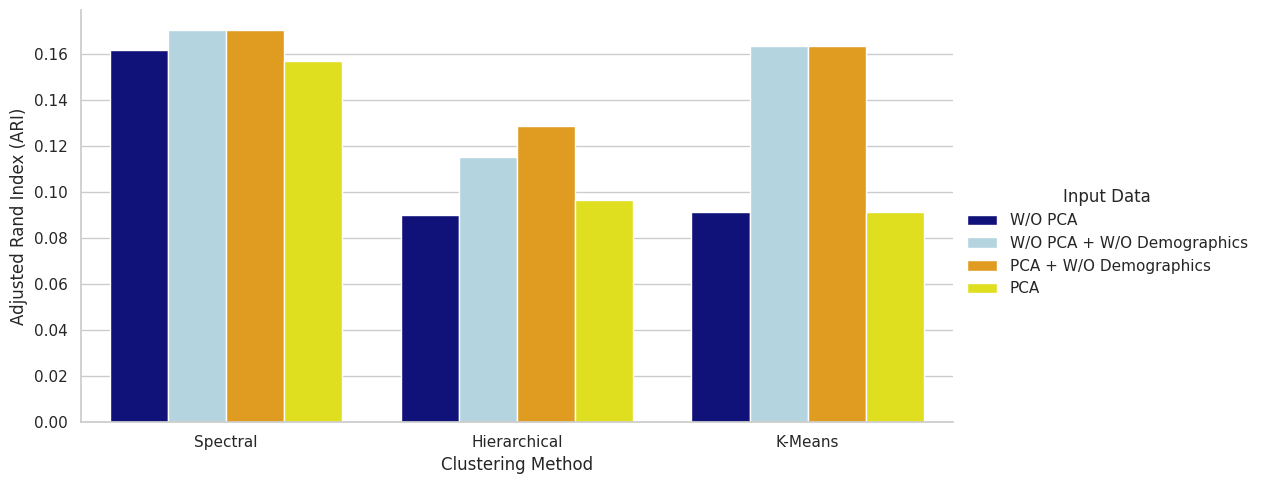

In [ ]:
# Visaulziaing ARI


# creating a datafremae for ease of visualizaiton
data = {
    'Group': ['W/O PCA', 'W/O PCA', 'W/O PCA',
              'W/O PCA + W/O Demographics', 'W/O PCA + W/O Demographics', 'W/O PCA + W/O Demographics',
              'PCA + W/O Demographics', 'PCA + W/O Demographics', 'PCA + W/O Demographics',
              'PCA', 'PCA', 'PCA'],
    'Method': ['Spectral', 'Hierarchical', 'K-Means'] * 4,
    'ARI Score': [ari_score_spectral_standard,ari_hierarchical_standard, ari_kmeans_standard,
           ari_score_spectral_short, ari_hierarchical_short, ari_kmeans_short,
           ari_score_spectral_short_PCA, ari_hierarchical_short_PCA, ari_kmeans_short_PCA,
           ari_score_spectral_Standard_PCA, ari_hierarchical_Standard_PCA, ari_kmeans_Standard_PCA]
}

df = pd.DataFrame(data)
#print(df.head())
color = ['darkblue','lightblue','orange','yellow']
g = sns.catplot(data=df, kind='bar', x='Method',y='ARI Score',hue='Group',ci=None,
                palette=color, height=5, aspect=2)


plt.xlabel('Clustering Method')
plt.ylabel('Adjusted Rand Index (ARI)')

# Adjust legend
g._legend.set_title('Input Data')

plt.show()


In [ ]:
# Agglomerative Clustering - better for clustering binary data using hamming distance measure instead of Euclidean. However, ZARI is very poor still 0.067
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
agg_clust = AgglomerativeClustering(n_clusters=3, affinity='hamming', linkage='complete')
clusters = agg_clust.fit_predict(lgg_data)
ari = metrics.adjusted_rand_score(labels_true["Primary_Diagnosis_numerical"].values, clusters)
print(ari)

0.06762386281385493
